# Setup

In [3]:
library(keras)
library(tensorflow)
tf$test$gpu_device_name()

Loaded Tensorflow version 2.10.0



[1] "/device:GPU:0"

In [126]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(
    repr.plot.res = 120,
    repr.plot.width = 20,
    repr.plot.height = 15, 
    repr.plot.pointsize = 12, 
    repr.plot.quality = 100
)
options(width=300)
    
numcores=8

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(reshape)
library(dtplyr)
library(vroom)
library(dplyr)

#library(icd)
`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

   
    setosa versicolor virginica
  1     50          0         0
  2      0          2        36
  3      0         48        14

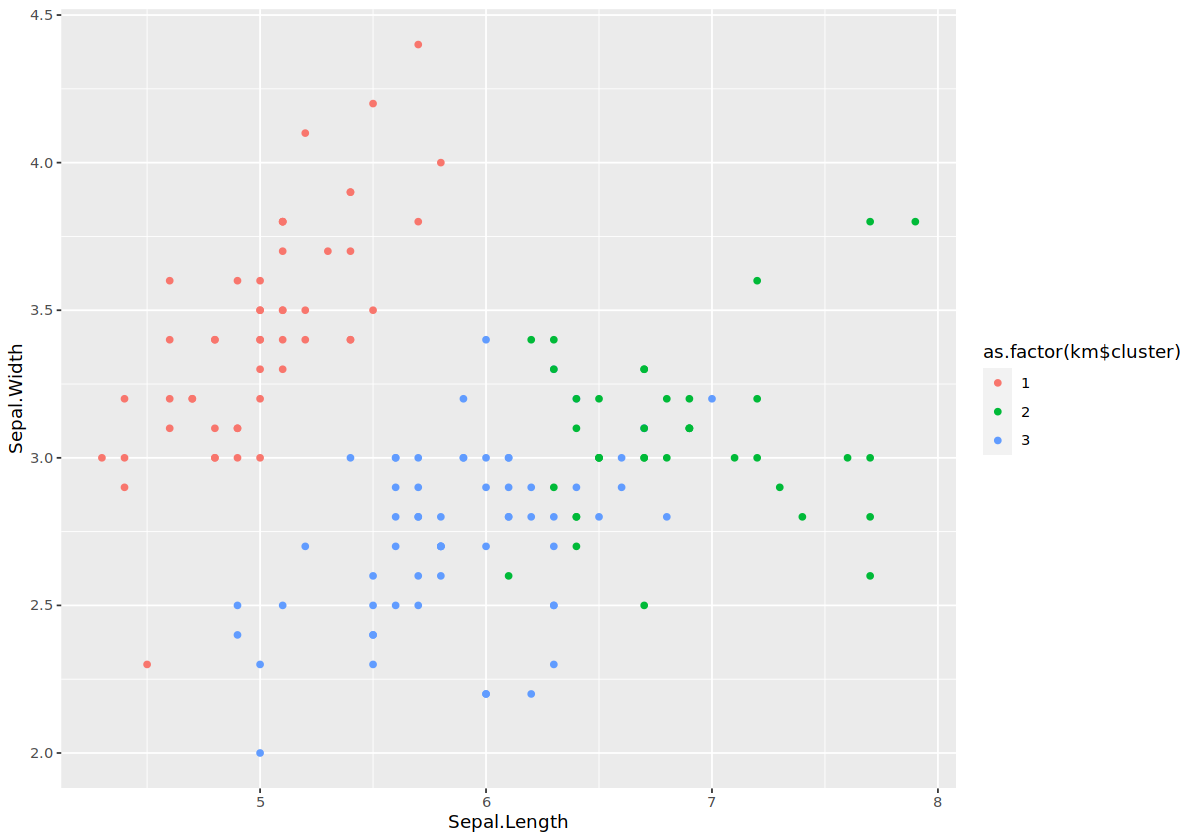

In [3]:
km <- kmeans(iris[, 1:4], 3)
ggplot(iris, aes(x = Sepal.Length, y = Sepal.Width, color = as.factor(km$cluster))) +
  geom_point()
table(km$cluster, iris$Species)

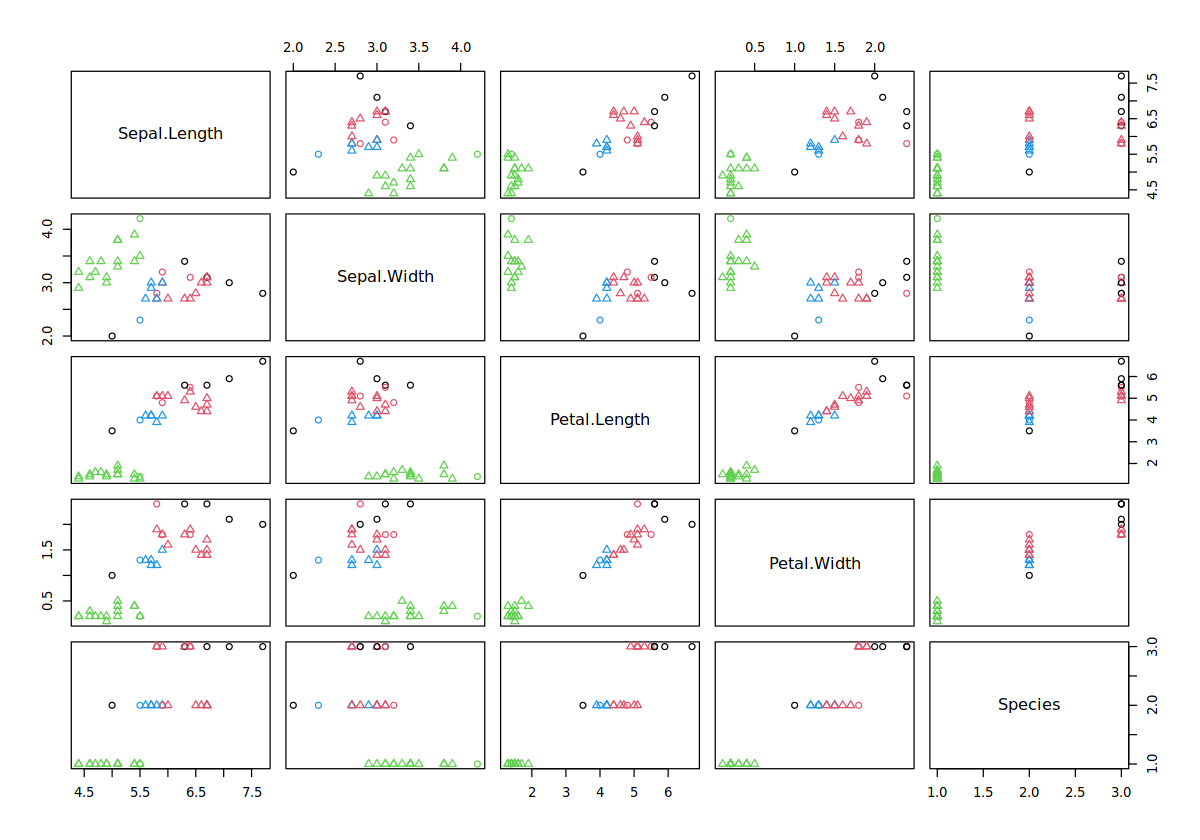

   
    setosa versicolor virginica
  0      0          1         4
  1      0          7         6
  2     16          0         0
  3      0          6         0

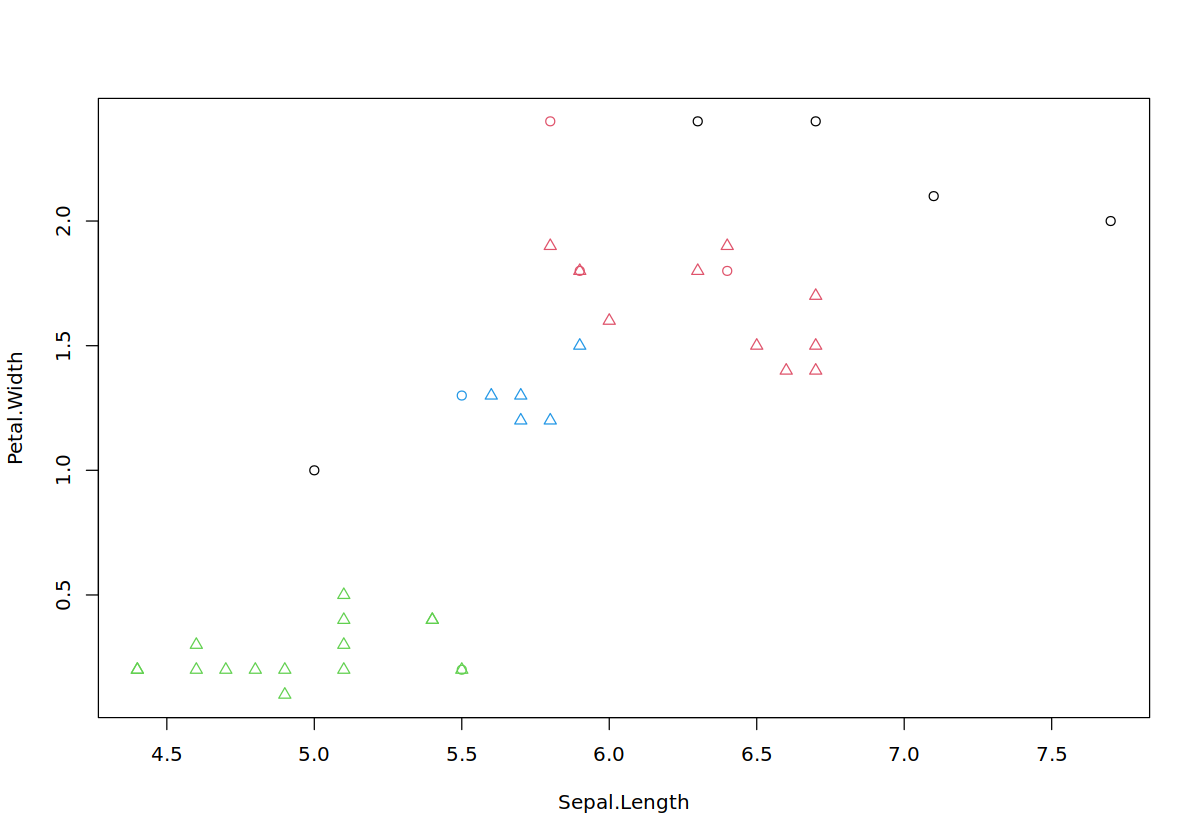

In [4]:
sampleiris <- iris[sample(1:150, 40), ] # get samples from iris dataset
library(fpc)
# eps is radius of neighborhood, MinPts is no of neighbors
# within eps
cluster <- dbscan(sampleiris[, -5], eps = 0.6, MinPts = 4)
plot(cluster, sampleiris)
plot(cluster, sampleiris[, c(1, 4)])
# Notice points in cluster 0 are unassigned outliers
table(cluster$cluster, sampleiris$Species)

In [16]:
model <- ... # create the original model
layer_name <- "my_layer"
intermediate_layer_model <- keras_model(
    inputs = model$input,
    outputs = get_layer(model, layer_name)$output
)
intermediate_output <- predict(intermediate_layer_model, data)

ERROR: Error in eval(expr, envir, enclos): '...' used in an incorrect context


# Extracting the needed data from the datasets
Here, we will create a data.table with the following columns:
* id: the unique identifier of each Medicare beneficiary
* year: the year of the Medicare claim
* diagnosis: the diagnosis code of the claim
* procedure: the procedure code of the claim
* provider: the provider of the claim
* provider_specialty: the specialty of the provider
* cost: the cost of the claim

We will only use 2016 to 2019 data for this analysis.
We exclude 2020 due to the COVID-19 pandemic. We exclude 2013-2015 due to use of the ICD-9 coding system.

## Read sample files

In [59]:
# save the sample to fst
carrier_data <- read_fst("carrier_data_sample.fst", as.data.table = TRUE)
inpatient_data <- read_fst("inpatient_data_sample.fst", as.data.table = TRUE)
outpatient_data <- read_fst("outpatient_data_sample.fst", as.data.table = TRUE)

In [64]:
# create a sample of 10000 patients based on id
sample_id = sample(carrier_data$id, 1000)

# sample the data based on the ids sampled
carrier_data = carrier_data[id %in% sample_id]
inpatient_data = inpatient_data[DESY_SORT_KEY %in% sample_id]
outpatient_data = outpatient_data[DESY_SORT_KEY %in% sample_id]


## Extract the diagnoses and procedures from the files

We will also turn all the data into wide format.

In [65]:
head(carrier_data)
head(inpatient_data)
head(outpatient_data)

id        diagnosis provider   provider_specialty hcpcs date     cost   year
1 100109031 C9200     1306844360 11                 99214 20160112  79.38 2016
2 100109031 C9200     1699837104 50                 99213 20160308  44.00 2016
3 100109031 C9200     1306844360 90                 99213 20160517  51.77 2016
4 100109031 H04123    1427052331 18                 92014 20160817 117.56 2016
5 100109031 N390      1043586662 50                 99213 20160823  61.83 2016
6 100109031 N390      1043586662 50                 81002 20160823   3.48 2016

DESY_SORT_KEY CLAIM_NO PRVDR_NUM CLM_THRU_DT NCH_NEAR_LINE_REC_IDENT_CD NCH_CLM_TYPE_CD CLAIM_QUERY_CODE CLM_FAC_TYPE_CD CLM_SRVC_CLSFCTN_TYPE_CD CLM_FREQ_CD FI_NUM CLM_MDCR_NON_PMT_RSN_CD CLM_PMT_AMT NCH_PRMRY_PYR_CLM_PD_AMT NCH_PRMRY_PYR_CD FI_CLM_ACTN_CD PRVDR_STATE_CD ORG_NPI_NUM
1 100193467     1439     360179    20161122    V                          60              3                1               1                        1           15201                           7842.32    0                                         1              36             1396714663 
2 100193467     1440     360354    20161227    V                          60              3                1               1                        1           15201                           5310.33    0                                         1              36             1851549273 
3 100407933     3053     420065    20161218    V                          60              3                1               1                        1           11201                           4692.60    0                                         1              42             1851361778 
4 100407933     3054     420087    20161221    V                          60              3                1               1                        1           11201                          17210.70    0                                         1              42             1962472860 
5 100473841     3626     210022    20160215    V                          60              3                1               1                        1           12301                           2689.19    0                                         1              21             1205896446 
6 100473841     3627     210022    20160330    V                          60              3                1               1                        1           12301                           3700.62    0                                         1              21             1205896446 
  AT_PHYSN_UPIN AT_PHYSN_NPI AT_PHYSN_SPCLTY_CD OP_PHYSN_UPIN OP_PHYSN_NPI OP_PHYSN_SPCLTY_CD OT_PHYSN_UPIN OT_PHYSN_NPI OT_PHYSN_SPCLTY_CD RNDRNG_PHYSN_NPI RNDRNG_PHYSN_SPCLTY_CD CLM_MCO_PD_SW PTNT_DSCHRG_STUS_CD CLM_PPS_IND_CD CLM_TOT_CHRG_AMT CLM_ADMSN_DT CLM_IP_ADMSN_TYPE_CD CLM_SRC_IP_ADMSN_CD
1               1518269018   NA                 NA                    NA   NA                 NA                    NA   NA                 NA               NA                     NA             3                   2             28561.05         20161117     1                    1                  
2               1104913938   NA                 NA            1447227111   NA                 NA            1104913938   NA                 NA               NA                     NA             6                   2             26356.50         20161222     1                    1                  
3               1659394377   NA                 NA                    NA   NA                 NA                    NA   NA                 NA               NA                     NA            82                   2             17732.89         20161216     1                    1                  
4               1629293212   NA                 NA            1407881709   NA                 NA                    NA   NA                 NA               NA                     NA            62                   2             64008.99         20161218     2                    1                  
5               1780861252   NA                 NA                    NA   NA                 NA                    NA   NA                 NA               NA                     NA             1                  NA              4304.94         20160213     1                    1                  
6               1447419841   NA                 NA            1275564593   NA                 NA                    NA   NA                 NA               NA                     NA           

DESY_SORT_KEY CLAIM_NO PRVDR_NUM CLM_THRU_DT NCH_NEAR_LINE_REC_IDENT_CD NCH_CLM_TYPE_CD CLAIM_QUERY_CODE CLM_FAC_TYPE_CD CLM_SRVC_CLSFCTN_TYPE_CD CLM_FREQ_CD FI_NUM CLM_MDCR_NON_PMT_RSN_CD CLM_PMT_AMT NCH_PRMRY_PYR_CLM_PD_AMT NCH_PRMRY_PYR_CD PRVDR_STATE_CD ORG_NPI_NUM SRVC_LOC_NPI_NUM
1 100109031     12252    100017    20160112    W                          40              3                1               3                        1           9101                           40.76       0                                         10             1811991227  1811991227      
2 100109031     12253    100017    20160208    W                          40              3                1               3                        1           9101                           13.32       0                                         10             1811991227  1811991227      
3 100109031     12254    100017    20160308    W                          40              3                1               3                        1           9101                           74.17       0                                         10             1811991227  1811991227      
4 100109031     12255    100017    20160405    W                          40              3                1               3                        1           9101                           33.45       0                                         10             1811991227  1811991227      
5 100109031     12256    100017    20160517    W                          40              3                1               3                        1           9101                           74.17       0                                         10             1811991227  1811991227      
6 100109031     12257    100017    20160719    W                          40              3                1               3                        1           9101                           13.32       0                                         10             1811991227  1811991227      
  AT_PHYSN_UPIN AT_PHYSN_NPI AT_PHYSN_SPCLTY_CD OP_PHYSN_UPIN OP_PHYSN_NPI OP_PHYSN_SPCLTY_CD OT_PHYSN_UPIN OT_PHYSN_NPI OT_PHYSN_SPCLTY_CD RNDRNG_PHYSN_NPI RNDRNG_PHYSN_SPCLTY_CD RFR_PHYSN_NPI RFR_PHYSN_SPCLTY_CD CLM_MCO_PD_SW PTNT_DSCHRG_STUS_CD CLM_TOT_CHRG_AMT NCH_BENE_BLOOD_DDCTBL_LBLTY_AM
1               1306844360   11                 NA            NA                              NA            NA                              NA                                      NA                                NA            1                   853              0                             
2               1306844360   11                 NA            NA                              NA            NA                              NA                                      NA                                NA            1                   180              0                             
3               1699837104   89                 NA            NA                              NA            NA                              NA                                      NA                                NA            1                   758              0                             
4               1306844360   11                 NA            NA                              NA            NA                              NA                                      NA                                NA            1                   323              0                             
5               1306844360   11                 NA            NA                              NA            NA                              NA                                      NA                                NA            1                   758              0                             
6               1306844360   11                 NA            NA                              NA            NA                              NA                                      NA                     

### Inpatient and outpatient

In [66]:
find_all_diagnosis=function(data){
    data=data[,.(
        id=DESY_SORT_KEY,
        year=year,
        #diagnosis_prncpl = PRNCPAL_DGNS_CD,
        diagnosis1=ICD_DGNS_CD1, 
        diagnosis2=ICD_DGNS_CD2,
        diagnosis3=ICD_DGNS_CD3,
        diagnosis4=ICD_DGNS_CD4,
        diagnosis5=ICD_DGNS_CD5,
        diagnosis6=ICD_DGNS_CD6,
        diagnosis7=ICD_DGNS_CD7,
        diagnosis8=ICD_DGNS_CD8,
        diagnosis9=ICD_DGNS_CD9,
        diagnosis10=ICD_DGNS_CD10,
        diagnosis11=ICD_DGNS_CD11,
        diagnosis12=ICD_DGNS_CD12,
        diagnosis13=ICD_DGNS_CD13,
        diagnosis14=ICD_DGNS_CD14,
        diagnosis15=ICD_DGNS_CD15,
        diagnosis16=ICD_DGNS_CD16,
        diagnosis17=ICD_DGNS_CD17,
        diagnosis18=ICD_DGNS_CD18,
        diagnosis19=ICD_DGNS_CD19,
        diagnosis20=ICD_DGNS_CD20,
        diagnosis21=ICD_DGNS_CD21,
        diagnosis22=ICD_DGNS_CD22,
        diagnosis23=ICD_DGNS_CD23,
        diagnosis24=ICD_DGNS_CD24,
        diagnosis25=ICD_DGNS_CD25,
        icd_procedure1 = ICD_PRCDR_CD1,
        icd_procedure2 = ICD_PRCDR_CD2,
        icd_procedure3 = ICD_PRCDR_CD3,
        icd_procedure4 = ICD_PRCDR_CD4,
        icd_procedure5 = ICD_PRCDR_CD5,
        icd_procedure6 = ICD_PRCDR_CD6,
        icd_procedure7 = ICD_PRCDR_CD7,
        icd_procedure8 = ICD_PRCDR_CD8,
        icd_procedure9 = ICD_PRCDR_CD9,
        icd_procedure10 = ICD_PRCDR_CD10,
        icd_procedure11 = ICD_PRCDR_CD11,
        icd_procedure12 = ICD_PRCDR_CD12,
        icd_procedure13 = ICD_PRCDR_CD13,
        icd_procedure14 = ICD_PRCDR_CD14,
        icd_procedure15 = ICD_PRCDR_CD15,
        icd_procedure16 = ICD_PRCDR_CD16,
        icd_procedure17 = ICD_PRCDR_CD17,
        icd_procedure18 = ICD_PRCDR_CD18,
        icd_procedure19 = ICD_PRCDR_CD19,
        icd_procedure20 = ICD_PRCDR_CD20,
        icd_procedure21 = ICD_PRCDR_CD21,
        icd_procedure22 = ICD_PRCDR_CD22,
        icd_procedure23 = ICD_PRCDR_CD23,
        icd_procedure24 = ICD_PRCDR_CD24,
        icd_procedure25 = ICD_PRCDR_CD25
    )]
    # melt the data to include the procedure and diagnosis codes in one column
    data = melt(data, id.vars = c("id", "year"))%>%as.data.table()

    # change the data to wide format so that each diagnosis code is a column and the value is the number of times the diagnosis code was used
    # and also each procedure code is a column and the value is the number of times the procedure code was used
    # the data will be more than the machine row limit so we will split the data based on id and then dcast then combine the data

    # split the data based on id
    data_split = split(data, list(data$id))

    # dcast the data, I will use mclapply to do this in parallel
    data_split = mclapply(data_split,
     function(x) {
        x = dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
        return(x)
    }, mc.cores = numcores)
    
    # combine the data back using a for loop
    data = data.table()
    for (i in 1:length(data_split)) {
        data = rbind(data, data_split[[i]], fill = TRUE)
    }

    # replace NA with 0

    data[is.na(data)] = 0
    
    return(data)
}

In [67]:
# Works fine, let's run it on the whole data
inpatient_data_wide = find_all_diagnosis(inpatient_data)

In [68]:
head(inpatient_data_wide)

id        year V1 A419 B0229 D693 J189 R000 Z8619 Z9081 4A033R1 5A09357 B246YZZ B246ZZZ D631 D649 E1122 E6601 E669 E869 E874 E875 I129 I130 I132 I161 I214 I2510 I25110 I429 I440 I480 I4891 I5033 I5043 I509 I959 J441 J9621 J9622 K219 M069 M109 M1710 M19019 M4800 N179 N184 N185 R040 R0902 R197 Z515
1 100109031 2019 43 1    1     1    1    1    1     1     0       0       0       0       0    0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     0    0    0    0    0     0    0   
2 100193467 2016 57 0    0     0    1    0    0     0     1       0       0       1       2    0    1     1     1    0    0    2    1    1    0    0    0    1     0      0    1    1    0     1     0     1    1    0    0     0     1    2    2    1     1      1     2    2    0    1    1     1    0   
3 100193467 2019 25 0    0     0    0    0    0     0     1       1       1       0       0    1    1     1     0    1    1    0    0    0    1    1    1    0     1      1    0    0    1     0     1     0    0    1    1     1     0    1    0    0     0      0     1    0    1    0    0     0    1   
4 100240641 2017 80 0    0     0    0    0    0     0     0       0       0       0       0    0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     1    0    0    0    0     0    0   
5 100240641 2018 33 0    0     0    0    0    0     0     0       0       0       0       0    1    0     0     0    0    0    0    0    1    0    0    0    0     0      0    0    0    0     0     0     1    0    0    0     0     0    0    0    0     0      0     1    1    0    0    0     0    0   
6 100240641 2019 96 0    0     0    0    0    0     0     0       0       0       0       0    0    0     0     0    0    0    0    2    1    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     2    0    0    0    0     0    1   
  Z66 Z6841 Z794 Z7952 Z7982 Z8673 Z9049 Z950 Z951 B964 E440 E860 E872 E876 F0151 F0390 F17210 F319 F322 F323 F333 F919 G4700 I10 I248 I351 I4581 I493 I5022 I6389 I69354 J309 J8410 K521 K5900 K8590 L89159 M6282 N182 N183 N189 N390 R262 R2689 R296 R29810 R32 R339 R402142 R402242 R402362 R402410 R451
1 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
2 0   2     1    1     1     1     1     2    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
3 1   0     0    0     0     0     0     1    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
4 0   0     0    0     0     2     0     0    0    0    0    1    1    0    0     0     1      0    0    0    0    0    0     2   0    0    0     0    0     0     0      0    0     0    0     1     1      1     0    0    0    0    1    1     1    0      0   0    0       0       0       1       0   
5 1   0     0    0     0     1     0     0    0    0    0    1    0    1    0     0     0      0    1    1    0    1    0     0   0    0    0     0    0     0     0      0    1     0    0     0     0      0     0    0    0    1    0    0     0    0      1   0    0       0       0       0       1   
6 2   0     0    0     1     2     0     0    0    1    1    1    0    0    1     2     1      1    0 

In [69]:
outpatient_data_wide = find_all_diagnosis(outpatient_data)

In [70]:
head(outpatient_data_wide)

id        year V1  A539 B0233 C9110 C9190 C91Z0 C91Z1 C9201 C9291 C92Z1 C9480 C9481 C969 D509 D649 D693 D709 D72821 D7589 E538 H409 H44001 H44119 I10 M6281 R21 R51 R531 R5383 R7301 Z08 Z5111 Z79899 Z856 Z862 Z8669 Z8739 D0000 D098 D631 E1122 E1165 E6601 E785 G459 G4730 I130 I1310 I1311 I2510 I480
1 100109031 2016 384 0    0     0     1     3     0     3     3     1     0     0     0    0    0     3   0    0      1     0    0    0      0      0   0     0   0   0    0     0     0   0     1      0    0    0     0     0     0    0    0     0     0     0    0    0     0    0     0     0     0   
2 100109031 2017 421 0    1     0     0     5     0     2     0     4     1     0     0    0    0     1   3    0      0     1    0    0      0      0   0     1   1   1    0     0     0   0     2      1    3    1     1     0     0    0    0     0     0     0    0    0     0    0     0     0     0   
3 100109031 2018 607 0    0     1     0     4     0     8     0     0     0     1     1    2    1    11   0    1      0     3    1    0      0      1   0     0   0   0    2     1     0   1     0      1    3    0     0     0     0    0    0     0     0     0    0    0     0    0     0     0     0   
4 100109031 2019 822 1    0     0     0     1     3     4     0     0     0     0     0    0    0     6   0    1      0     0    0    3      1      0   5     0   0   0    1     0     1   0     1      0    0    0     0     0     0    0    0     0     0     0    0    0     0    0     0     0     0   
5 100193467 2016 338 0    0     0     0     0     0     0     0     0     0     0     0    0    0     0   0    0      0     0    0    0      0      1   0     0   0   0    0     0     0   0     0      0    0    0     0     0     0    4    0     1     0     0    0    0     0    0     0     0     0   
6 100193467 2017 885 0    0     0     0     0     0     0     0     0     0     0     0    1    0     0   0    0      0     0    0    0      0      0   0     0   0   0    0     0     0   0     1      0    0    0     0     0     0    6    5     0     1     0    1    1     6    0     0     1     1   
  I5030 I5032 I509 I729 J22 J948 K668 M069 M109 M19011 M19012 N179 N181 N183 N184 N186 N189 N2889 R072 R200 R710 R7309 R918 Z0000 Z6841 Z794 Z951 C44321 D485 F0390 F17210 F319 G4700 H2513 H269 I129 I4581 I469 I69398 K8590 L570 M4806 N390 N401 R1310 R1312 R262 R269 R279 R339 R402142 R402242 R402362
1 0     0     0    0    0   0    0    0    0    0      0      0    0    0     0   0    0    0     0    0    0    0     0    0     0     0    0    0      0    0     0      0    0     0     0    0    0     0    0      0     0    0     0    0    0     0     0    0    0    0    0       0       0      
2 0     0     0    0    0   0    0    0    0    0      0      0    0    0     0   0    0    0     0    0    0    0     0    0     0     0    0    0      0    0     0      0    0     0     0    0    0     0    0      0     0    0     0    0    0     0     0    0    0    0    0       0       0      
3 0     0     0    0    0   0    0    0    0    0      0      0    0    0     0   0    0    0     0    0    0    0     0    0     0     0    0    0      0    0     0      0    0     0     0    0    0     0    0      0     0    0     0    0    0     0     0    0    0    0    0       0       0      
4 0     0     0    0    0   0    0    0    0    0      0      0    0    0     0   0    0    0     0    0    0    0     0    0     0     0    0    0      0    0     0      0    0     0     0    0    0     0    0      0     0    0     0    0    0     0     0    0    0    0    0       0       0      
5 0     0     0    0    0   0    0    0    0    1      1      0    0    4     0   0    0    0     0    0    0    0     0    0     0     0    0    0      0    0     0      0    0     0     0    0    0     0    0      0     0    0     0    0    0     0     0    0    0    0    0       0       0      
6 0     6     2    1    1   1    0    1    1    0      0      0    1    6    10   1    2    0     1    1    

### Carrier

In [71]:
# create a similar function for carrier data
find_all_diagnosis_carrier=function(data){
    data = data[, .(
        id = id,
        year = year,
        # diagnosis_prncpl = PRNCPAL_DGNS_CD,
        diagnosis = diagnosis,
        hcpcs = hcpcs
    )]
    
    # melt the data to include the procedure and diagnosis codes in one column
    data = melt(data, id.vars = c("id", "year"))%>%as.data.table()

    # change the data to wide format so that each diagnosis code is a column and the value is the number of times the diagnosis code was used
    # and also each procedure code is a column and the value is the number of times the procedure code was used
    # the data will be more than the machine row limit so we will split the data based on id and year and then dcast then combine the data

    # split the data based on id
    data_split = split(data, list(data$id))

    # dcast the data, I will use mclapply to do this in parallel
    data_split = mclapply(data_split,
     function(x) {
        x = dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
        return(x)
    }, mc.cores = numcores)
    
    # combine the data back using a for loop
    data = data.table()
    for (i in 1:length(data_split)) {
        data = rbind(data, data_split[[i]], fill = TRUE)
    }

    # replace NA with 0

    data[is.na(data)] = 0

    return(data)
}

In [72]:
# Works fine, let's run it on the whole data
carrier_data_wide = find_all_diagnosis_carrier(carrier_data)

In [73]:
head(carrier_data_wide)

id        year 11100 14060 17311 3341F 36415 65400 67028 67515 7025F 70450 71046 76512 77052 77063 77080 80053 80061 81002 82043 82570 82607 82728 83615 85025 85045 86255 87077 87086 87088 87186 88189 88305 90662 90670 90732 92002 92012 92014 92134 92225 92226 92235 92250 93010 98940 99024 99203
1 100109031 2016 0     0     0     1     2     0     0     0     1     0     0     0     1     1     0     2     0     1     0     0     1     1     2      2    2     0     1     1     1     1     0     0     0     0     0     0      0    1     0     0     0     0     0     0      0    0     0    
2 100109031 2017 1     1     1     0     4     0     0     0     0     1     0     0     0     0     1     3     1     0     0     0     2     2     1      4    1     0     0     0     0     0     0     1     1     0     0     0      9    0     0     0     0     0     0     1      0    1     1    
3 100109031 2018 0     0     0     0     0     0     0     3     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0      0    0     0     0     0     0     0     2     0     1     1     0     1     22    1     0     0     0     0     0     0     15    0     0    
4 100109031 2019 0     0     0     0     1     1     4     0     0     0     1     4     0     0     0     1     1     0     1     1     0     0     0      1    0     1     0     0     0     0     0     0     1     0     1     0     10    2     4     1     1     1     5     1      0    0     0    
5 100193467 2016 0     0     0     0     2     0     3     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     12    0     0     0     0     0     0     0     0     0     0     0     0      0    0     2     0     0     0     1     2      0    0     0    
6 100193467 2017 0     0     0     0     2     0     0     0     0     1     0     0     0     0     0     0     1     0     0     1     0     0     0     13    0     0     1     3     3     1     0     0     0     1     0     0      0    0     0     0     0     0     0     1      0    0     2    
  99204 99212 99213 99214 99215 99221 99232 99285 A0425 A0427 A419 A539 B0052 B0229 B0230 B0233 B0239 C44311 C9200 C92Z1 C969 D485 D509 D693 D72820 D72821 G0008 G0009 G0202 G0439 G4489 G8427 H04123 H16231 H18231 H18421 H30131 H3021 H40051 H43391 H43813 H5461 I10 I119 J189 L821 M810 M9903 M9904 N390
1 0     0     5      1    0     0      0    0     0     0     0    0    0     0     0      0    0     0      17    0     0    0    0     0   0      0      0     0     1     0     0     0     1      0      0      0       0     0      0     0      0      0     0   0    0    0    0    0      0    6   
2 0     0     5      2    0     0      0    1     1     1     0    0    0     3     5      5    0     3      15    1     0    1    0     0   0      0      1     0     0     0     2     0     0      0      0      0       0     0      0     0      0      0     0   6    0    1    1    0      0    0   
3 1     1     8     25    2     0      0    0     0     0     0    0    7     2     0     15    0     0      14    0     3    1    0    11   1      1      1     1     0     1     0     2     0      1      0      0       0     0     10     0      1      0     0   0    0    0    0    4     11    0   
4 1     1     6      2    0     1      1    1     0     0     2    1    0     0     0      6    4     0       0    0     3    0    1     0   0      0      1     1     0     1     0     0     0      0      1      2      19     1      0     3      0      1     6   0    1    0    0    0      0    0   
5 0     1     6      7    1     0     11    2     2     1     0    0    0     0     0      0    0     0       0    0     0    0    0     0   0      0      0     0     0     0     0     3     0      0      0      0       0     0      0     0      0      0     8   0    7    0    0    0      0    0   
6 0     0     7      8    1     0      0    1     0     0     0    0    0     0     0      0    0     0      

In [74]:
dim(carrier_data_wide)

[1]  3450 11621

### Putting things together

In [89]:
# Now, let's put things together

# list data
data_list = list(inpatient_data_wide, outpatient_data_wide, carrier_data_wide)
# rbind
wide_data = rbindlist(data_list, fill = TRUE)
# sum based on year and id
wide_data <-
    wide_data %>%
    group_by(id, year) %>%
    summarise_all(sum, na.rm = TRUE)%>%
    as.data.table()

#change NA to 0

wide_data[is.na(wide_data)] = 0

In [92]:
head(wide_data)

id        year V1  A419 B0229 D693 J189 R000 Z8619 Z9081 4A033R1 5A09357 B246YZZ B246ZZZ D631 D649 E1122 E6601 E669 E869 E874 E875 I129 I130 I132 I161 I214 I2510 I25110 I429 I440 I480 I4891 I5033 I5043 I509 I959 J441 J9621 J9622 K219 M069 M109 M1710 M19019 M4800 N179 N184 N185 R040 R0902 R197
1 100109031 2016 384 0    0      3   0    0    0     0     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0   
2 100109031 2017 421 0    3      1   0    0    0     0     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0   
3 100109031 2018 607 0    2     22   0    0    0     0     0       0       0       0        0   1    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0   
4 100109031 2019 865 3    1      7   2    2    1     1     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0   
5 100193467 2016 395 0    0      0   8    0    0     0     1       0       0       1       15   0    1     1     1    0    0    2    1    1    0    0    0    2     0      0    1    1    0     4     0     17   1    0    0     0     1    2    2    1     1      1     5     3   0    1    1     2   
6 100193467 2017 885 0    0      0   1    0    0     0     0       0       0       0       19   0    5     1     0    0    0    0    0    8    0    0    0    2     0      0    0    1    0     0     0      4   0    0    0     0     0    1    1    0     0      0     0    22   0    2    0     0   
  Z515 Z66 Z6841 Z794 Z7952 Z7982 Z8673 Z9049 Z950 Z951 B964 E440 E860 E872 E876 F0151 F0390 F17210 F319 F322 F323 F333 F919 G4700 I10 I248 I351 I4581 I493 I5022 I6389 I69354 J309 J8410 K521 K5900 K8590 L89159 M6282 N182 N183 N189 N390 R262 R2689 R296 R29810 R32 R339 R402142 R402242 R402362 R402410
1 0    0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    6    0    0     0    0      0   0    0       0       0       0      
2 0    0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0      
3 0    0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     1   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0      
4 0    0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     6   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0      
5 0    0   2     1    1     1     1     1     4    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0     9   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    37   0    0    0    2     0    0      0   0    0       0       0       0      
6 0    0   1     1    0     0     0     0     1    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0    

In [93]:
# save the data to fst
write.fst(wide_data, "wide_data_sample.fst")

# Dimensionality reduction
Based on the high number of diagnosis and procedure codes, we will use dimensionality reduction to reduce the number of features before clustering.

We will use two methods:
* PCA: Principal Component Analysis
* Autoencoder: a neural network that learns to reconstruct the input

In [287]:
# read the data from fst
wide_data = read.fst("wide_data_sample.fst", as.data.table = TRUE)
# drop V1
wide_data = wide_data[, "V1" := NULL]

In [288]:
head(wide_data)

id        year A419 B0229 D693 J189 R000 Z8619 Z9081 4A033R1 5A09357 B246YZZ B246ZZZ D631 D649 E1122 E6601 E669 E869 E874 E875 I129 I130 I132 I161 I214 I2510 I25110 I429 I440 I480 I4891 I5033 I5043 I509 I959 J441 J9621 J9622 K219 M069 M109 M1710 M19019 M4800 N179 N184 N185 R040 R0902 R197 Z515
1 100109031 2016 0    0      3   0    0    0     0     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0    0   
2 100109031 2017 0    3      1   0    0    0     0     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0    0   
3 100109031 2018 0    2     22   0    0    0     0     0       0       0       0        0   1    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0    0   
4 100109031 2019 3    1      7   2    2    1     1     0       0       0       0        0   0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0      0   0    0    0     0     0    0    0    0     0      0     0     0   0    0    0     0    0   
5 100193467 2016 0    0      0   8    0    0     0     1       0       0       1       15   0    1     1     1    0    0    2    1    1    0    0    0    2     0      0    1    1    0     4     0     17   1    0    0     0     1    2    2    1     1      1     5     3   0    1    1     2    0   
6 100193467 2017 0    0      0   1    0    0     0     0       0       0       0       19   0    5     1     0    0    0    0    0    8    0    0    0    2     0      0    0    1    0     0     0      4   0    0    0     0     0    1    1    0     0      0     0    22   0    2    0     0    0   
  Z66 Z6841 Z794 Z7952 Z7982 Z8673 Z9049 Z950 Z951 B964 E440 E860 E872 E876 F0151 F0390 F17210 F319 F322 F323 F333 F919 G4700 I10 I248 I351 I4581 I493 I5022 I6389 I69354 J309 J8410 K521 K5900 K8590 L89159 M6282 N182 N183 N189 N390 R262 R2689 R296 R29810 R32 R339 R402142 R402242 R402362 R402410 R451
1 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    6    0    0     0    0      0   0    0       0       0       0       0   
2 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0       0   
3 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     1   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0       0   
4 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     6   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0     0   0    0    0    0     0    0      0   0    0       0       0       0       0   
5 0   2     1    1     1     1     1     4    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0     9   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    37   0    0    0    2     0    0      0   0    0       0       0       0       0   
6 0   1     1    0     0     0     0     1    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0  

In [294]:
# create a dataset that is only based on the presence of procedures and diagnoses and not numbers
wide_data_presence <- wide_data[, (.SD > 0)*1, .SDcols = colnames(wide_data)[-c(1, 2)]]

# add id and year
wide_data_presence <- cbind(wide_data[, c("id", "year")], wide_data_presence)
head(wide_data_presence)

id        year A419 B0229 D693 J189 R000 Z8619 Z9081 4A033R1 5A09357 B246YZZ B246ZZZ D631 D649 E1122 E6601 E669 E869 E874 E875 I129 I130 I132 I161 I214 I2510 I25110 I429 I440 I480 I4891 I5033 I5043 I509 I959 J441 J9621 J9622 K219 M069 M109 M1710 M19019 M4800 N179 N184 N185 R040 R0902 R197 Z515
1 100109031 2016 0    0     1    0    0    0     0     0       0       0       0       0    0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     0    0    0    0    0     0    0   
2 100109031 2017 0    1     1    0    0    0     0     0       0       0       0       0    0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     0    0    0    0    0     0    0   
3 100109031 2018 0    1     1    0    0    0     0     0       0       0       0       0    1    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     0    0    0    0    0     0    0   
4 100109031 2019 1    1     1    1    1    1     1     0       0       0       0       0    0    0     0     0    0    0    0    0    0    0    0    0    0     0      0    0    0    0     0     0     0    0    0    0     0     0    0    0    0     0      0     0    0    0    0    0     0    0   
5 100193467 2016 0    0     0    1    0    0     0     1       0       0       1       1    0    1     1     1    0    0    1    1    1    0    0    0    1     0      0    1    1    0     1     0     1    1    0    0     0     1    1    1    1     1      1     1    1    0    1    1     1    0   
6 100193467 2017 0    0     0    1    0    0     0     0       0       0       0       1    0    1     1     0    0    0    0    0    1    0    0    0    1     0      0    0    1    0     0     0     1    0    0    0     0     0    1    1    0     0      0     0    1    0    1    0     0    0   
  Z66 Z6841 Z794 Z7952 Z7982 Z8673 Z9049 Z950 Z951 B964 E440 E860 E872 E876 F0151 F0390 F17210 F319 F322 F323 F333 F919 G4700 I10 I248 I351 I4581 I493 I5022 I6389 I69354 J309 J8410 K521 K5900 K8590 L89159 M6282 N182 N183 N189 N390 R262 R2689 R296 R29810 R32 R339 R402142 R402242 R402362 R402410 R451
1 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    1    0    0     0    0      0   0    0       0       0       0       0   
2 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     0   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
3 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     1   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
4 0   0     0    0     0     0     0     0    0    0    0    0    0    0    0     0     0      0    0    0    0    0    0     1   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    0    0    0    0    0     0    0      0   0    0       0       0       0       0   
5 0   1     1    1     1     1     1     1    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0     1   0    0    0     0    0     0     0      0    0     0    0     0     0      0     0    1    0    0    0    1     0    0      0   0    0       0       0       0       0   
6 0   1     1    0     0     0     0     1    1    0    0    0    0    0    0     0     0      0    0    0    0    0    0  

## PCA

In [96]:
install.packages("FactoMineR")
install.packages("factoextra")

که پیش‌نیاز هستند نیز نصب می‌شوند ‘later’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘estimability’, ‘xtable’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggrepel’ ‌بسته‌های





The downloaded binary packages are in
	/var/folders/gr/r594hq9j4klg4g_b0qwqkpdc0000gp/T//Rtmp4wuqGt/downloaded_packages


که پیش‌نیاز هستند نیز نصب می‌شوند ‘corrplot’, ‘viridis’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘dendextend’, ‘ggpubr’ ‌بسته‌های





The downloaded binary packages are in
	/var/folders/gr/r594hq9j4klg4g_b0qwqkpdc0000gp/T//Rtmp4wuqGt/downloaded_packages


In [295]:
# do PCA on the wide_data
library(FactoMineR)
library(factoextra)

# perform the PCA
pca <- PCA(wide_data[, -c("id", "year")], graph = FALSE, ncp = 20)

In [265]:
predictions <- predict(pca, wide_data[, -c("id", "year")], ncp=20)

In [266]:
coords_pred <- data.table(id = wide_data$id, year = wide_data$year, predictions$coord)

In [267]:
head(coords_pred)

id        year Dim.1      Dim.2      Dim.3       Dim.4      Dim.5       Dim.6       Dim.7       Dim.8         Dim.9       Dim.10     Dim.11      Dim.12     Dim.13      Dim.14     Dim.15     Dim.16      Dim.17     Dim.18     Dim.19     Dim.20     
1 100109031 2016 -3.3118139 -1.3524281 -0.89190169 -0.9197770 -1.28652896 -0.02975049 -0.08794351  0.0340467412 -0.19674014 -0.8783654 -0.31636593 -0.2439864 -0.05073581 -0.2270572 -0.7340395 -0.30411471 -0.6949111 -0.3537275 -0.2126269 -0.23398052
2 100109031 2017 -3.0521679 -1.1547191 -0.53499119 -1.0654734 -1.67246077 -0.40083796  0.32659425 -0.4427450632 -0.37858242 -0.9681059  0.06701830 -0.2339495  0.07329308 -0.4596011 -0.6420958 -0.06211656 -1.0035881 -0.4496760 -0.1510599  0.24928663
3 100109031 2018 -3.3194844 -1.1948927 -0.52236559 -1.3928903 -1.84947358 -0.50390910  0.21299751 -0.4572459670 -0.49361591 -0.7827848 -0.22666365 -0.3007655  0.29076535 -0.4749698 -0.6966949 -0.10204745 -0.5325066 -0.2059730  0.1794457  0.28249524
4 100109031 2019 -3.0723135 -0.9681790 -2.06704400 -1.5818618 -1.64426533 -0.02253912 -0.25945501 -0.1318014589 -0.42404184 -1.0690563 -0.51810674 -0.2296702  0.07299691 -0.3444675 -0.9021036 -0.41185920 -1.3266291 -0.1510279 -0.5937128 -0.26522152
5 100193467 2016  0.4735530 -0.5510005 -0.07352458 -1.4285299 -0.12145775 -0.31954482 -0.02862072  0.0005475574 -0.09449416 -0.6754299 -1.17821901 -0.8182211  0.15965187  0.3128692  0.1345106 -0.15696121 -0.6928458 -0.2122003 -0.4540361 -0.27377847
6 100193467 2017 -0.6200972  0.1495867  0.15114480 -0.9674087 -0.01179043  0.02627832 -0.65963994 -0.0676150277  0.53617507 -0.3090593  0.08403303 -0.4253497 -1.04137245  1.1885158  0.3475250 -0.98443439 -0.7243031 -0.1955146  0.6228851 -0.03750804

In [268]:
# winsorise all dims of coords_pred
library(DescTools)
coords_pred <-
    coords_pred %>%
    mutate_at(vars(-c("id", "year")),
    Winsorize, probs = c(0.05, 0.95)) %>%
    as.data.table()

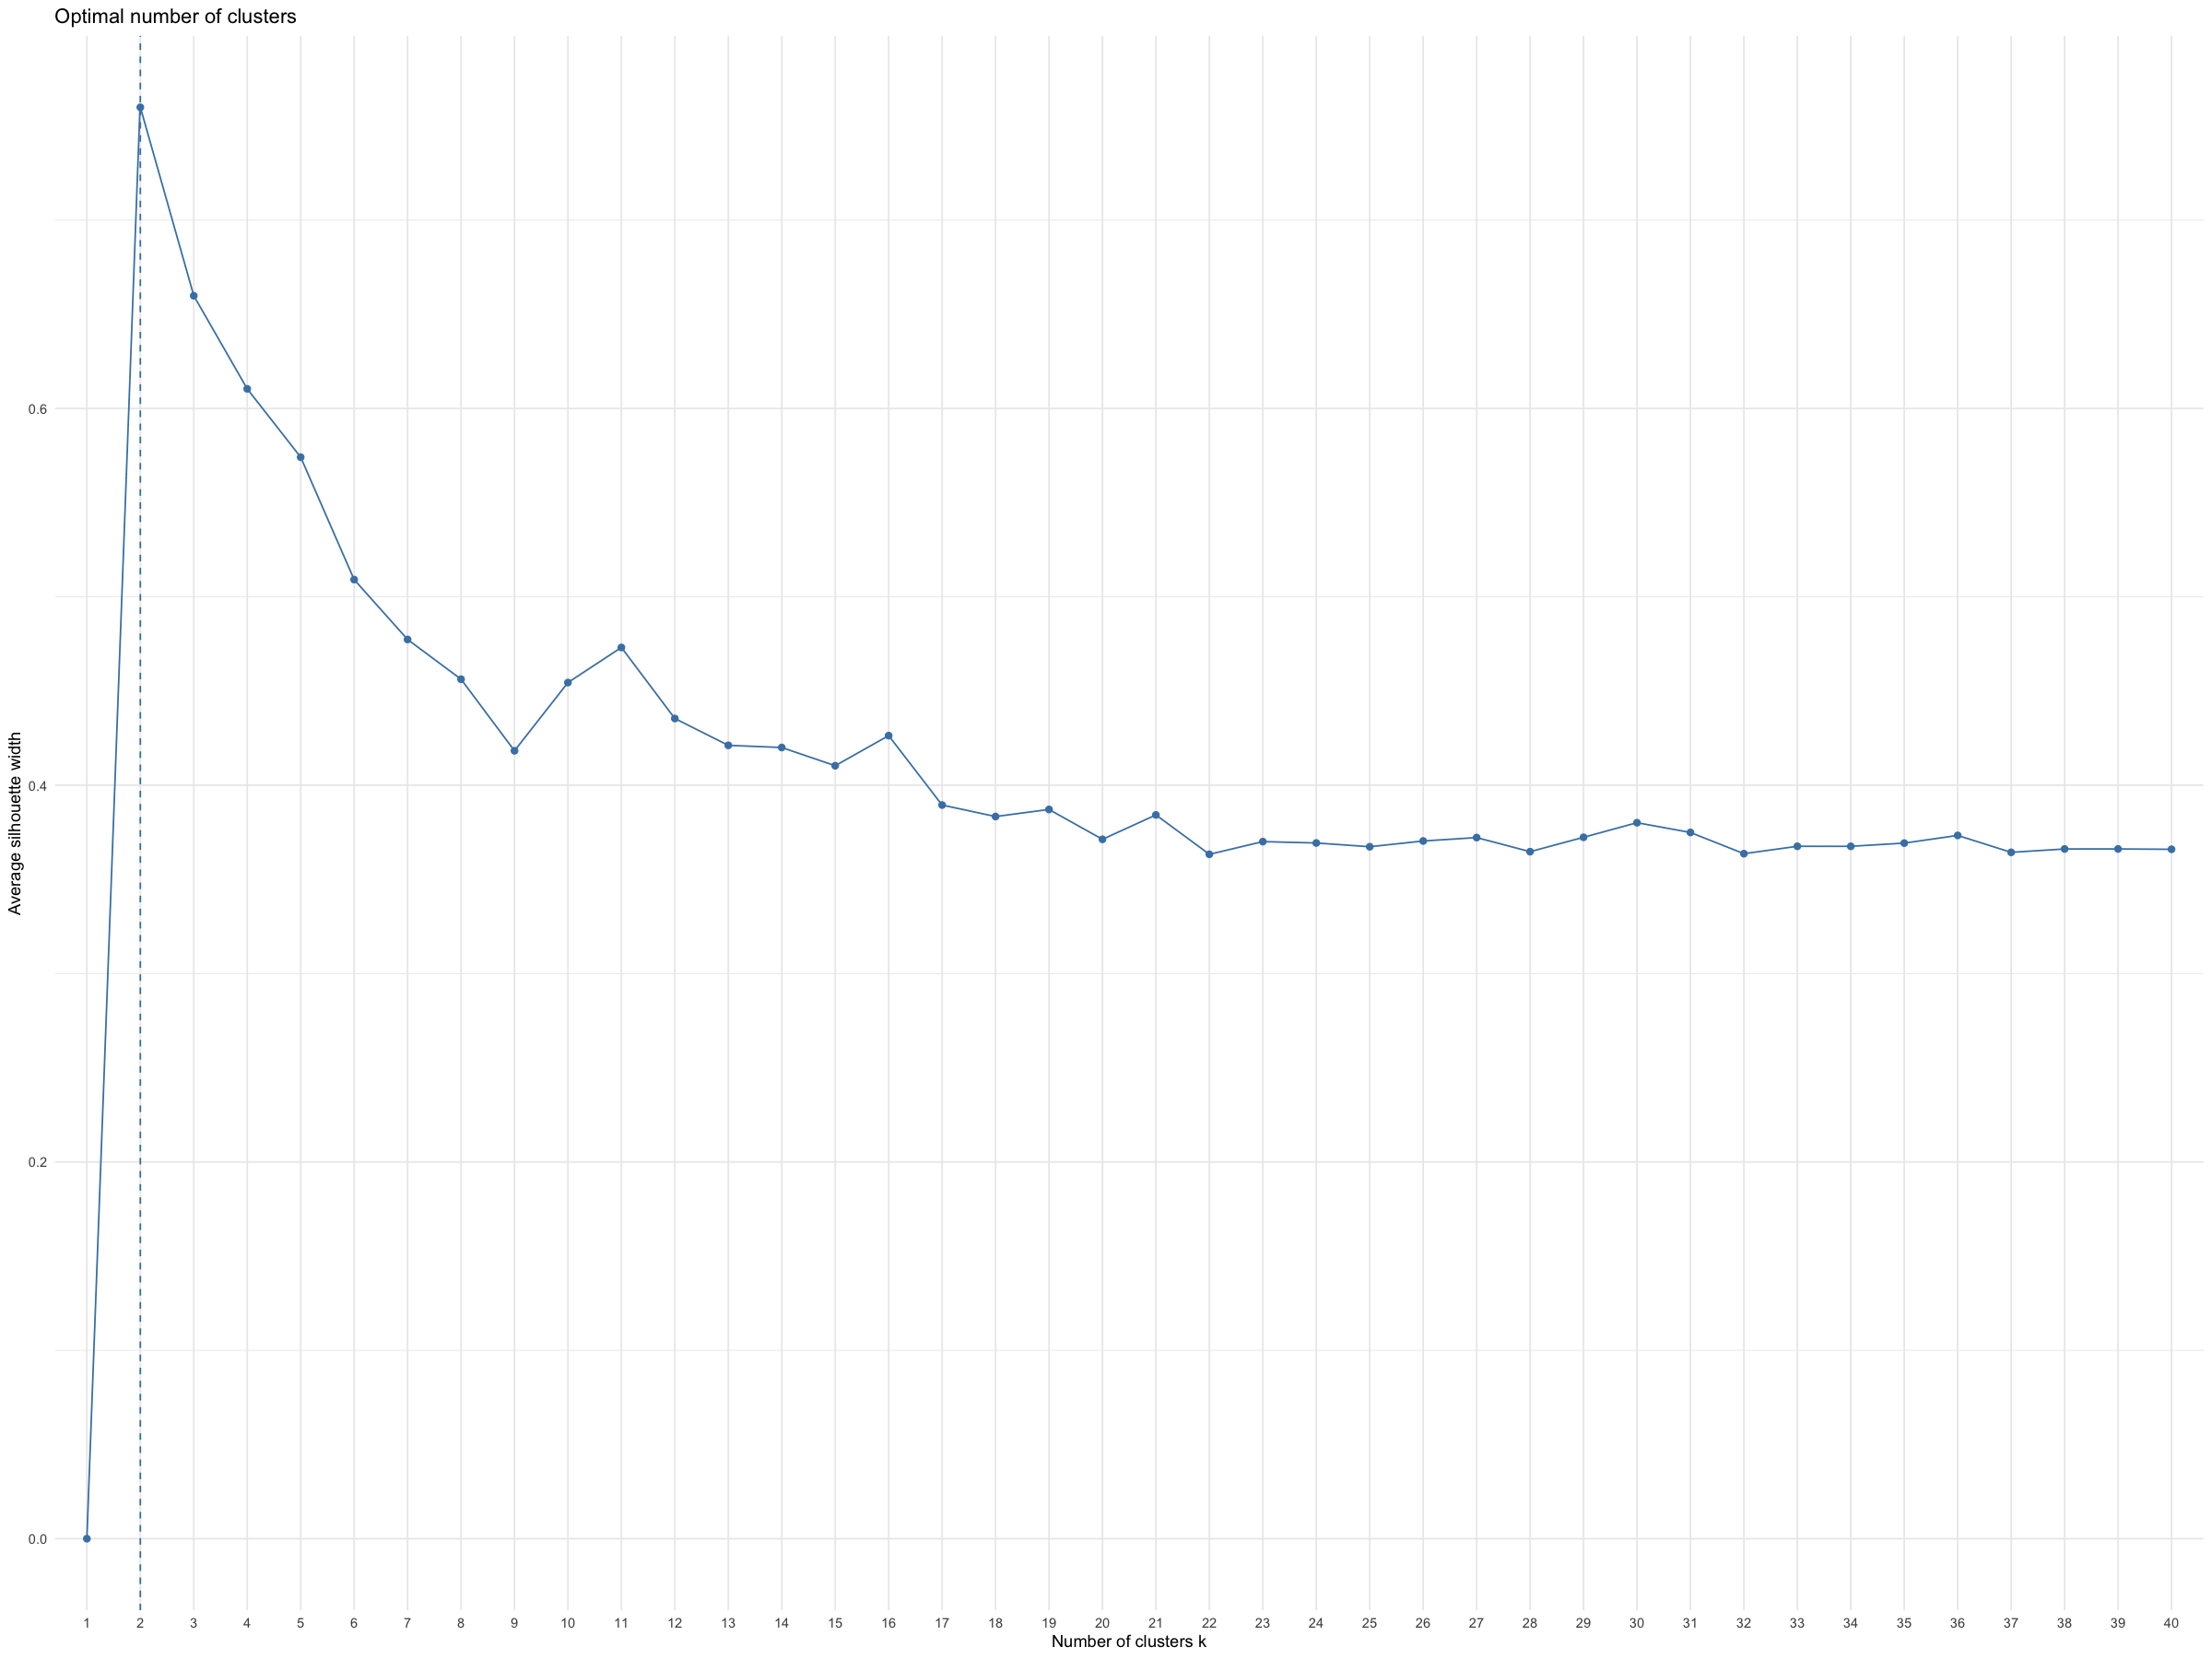

In [190]:
#remove outliers

# run clustering on predictions
library(cluster)
library(factoextra)

fviz_nbclust(coords_pred[, -c("id", "year")], FUNcluster = kmeans, method = "silhouette", k.max = 40,  iter.max = 30) +
    theme_minimal()

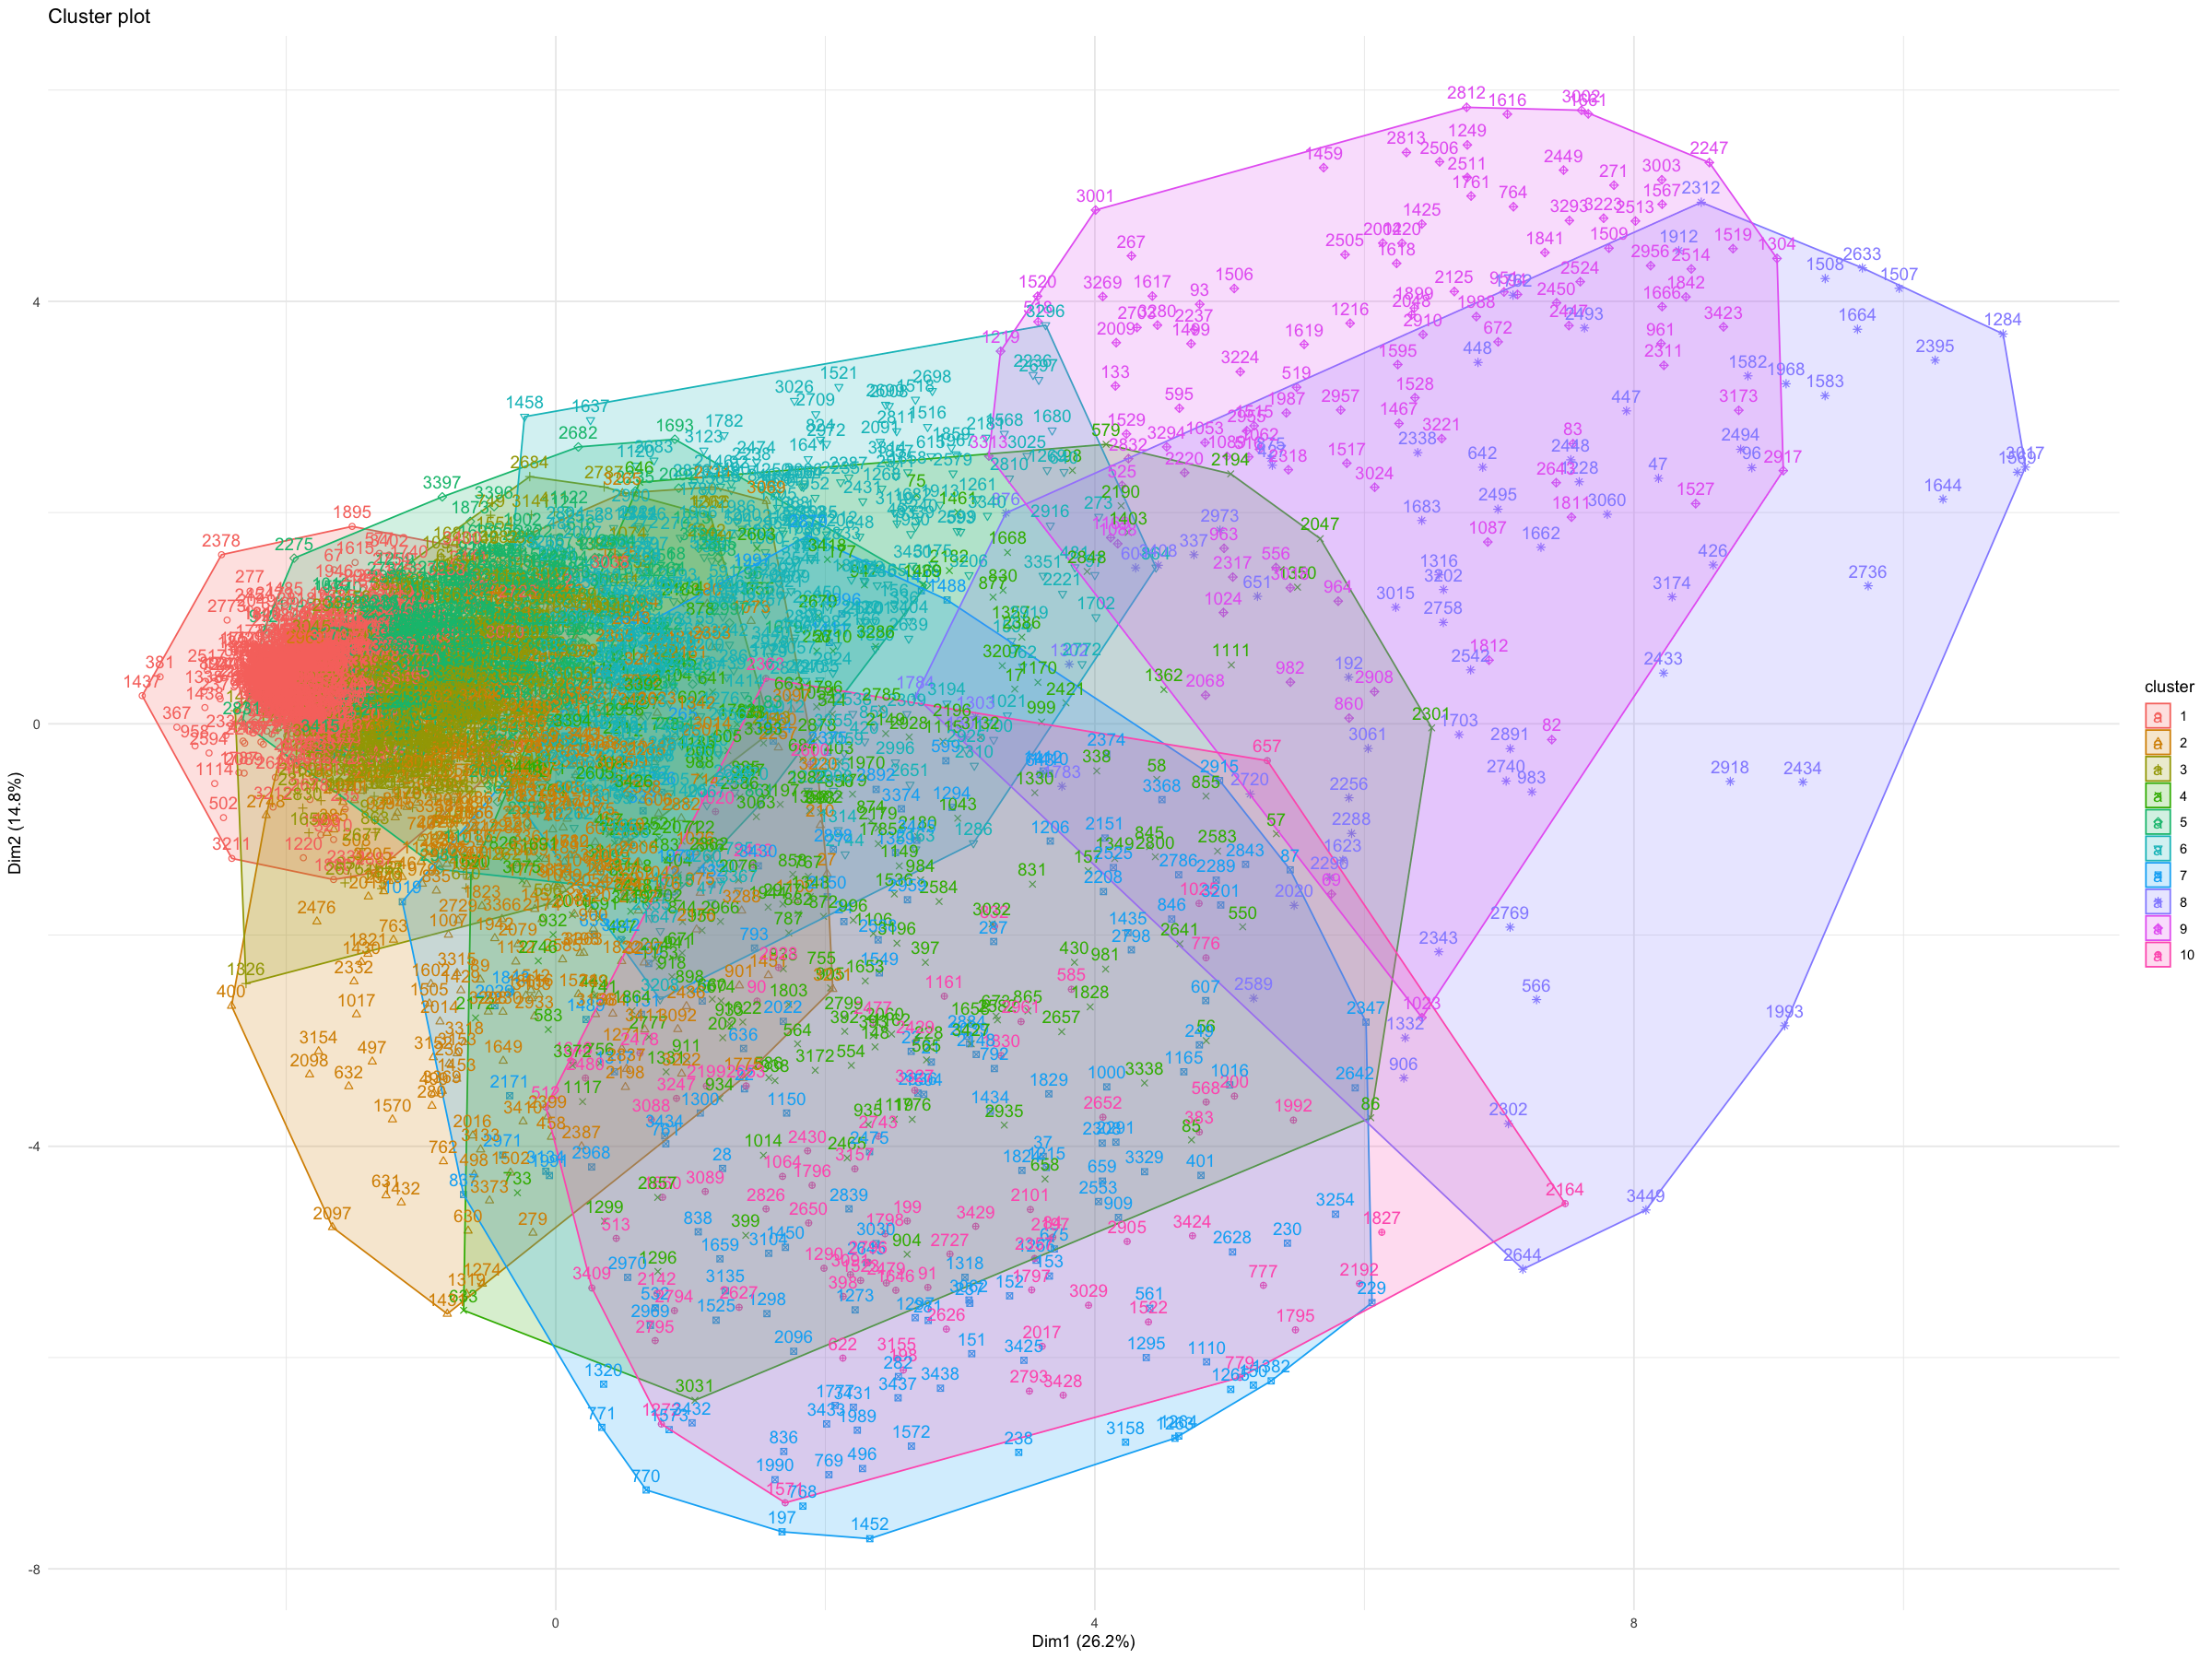

In [269]:

# run k medoids
kmedoids_results <- pam(coords_pred[, -c("id", "year")],
    k = 10, metric = "manhattan"
)
# plot the clusters
fviz_cluster(kmedoids_results,
 data = coords_pred[, -c("id", "year")],
  ellipse.type = "convex", repel = F) +
    theme_minimal()

# add the cluster to the data
wide_data$cluster = kmedoids_results$clustering

id        year Dim.1      Dim.2      Dim.3     Dim.4      Dim.5      Dim.6       Dim.7       Dim.8      Dim.9      Dim.10     Dim.11      Dim.12     Dim.13     Dim.14      Dim.15      Dim.16     Dim.17     Dim.18     Dim.19     Dim.20     
1 100109031 2016 -5.8100179 -0.8957200 -2.444922 -1.8090319 -1.4697596  0.27820151 -0.35016881  0.5296627 -0.2163041  0.2320403 -0.75634550 0.07936123 -0.7307379 -0.12287163 -0.31120364 -1.3984174 -0.7547464 -0.1006680 -0.1143281 -0.95308563
2 100109031 2017 -4.5460051 -0.5443127 -2.787859 -1.9824038 -1.2802246  1.24345884 -0.07220113 -0.1944573 -0.1317163 -0.4106617 -0.06504025 0.37145588 -1.0032831 -0.49220155 -0.39291642 -1.4143000 -1.4209812  0.3371657  0.2673547 -0.97857780
3 100109031 2018 -5.1313501 -0.8368361 -3.206325 -2.4920929 -1.3285458  1.61564567 -0.25791209  0.1494187  0.4121334 -0.6597368 -0.40784044 0.12810985 -1.2908737 -0.25911603 -0.73190168 -2.3641977 -1.7805335  0.4560251  0.8377629 -0.93882996
4 100109031 2019 -4.6030396 -1.2864906 -2.944649 -2.1531941 -1.6859772  0.02757567 -0.65935671  0.7726630  0.3897515 -0.5048334 -0.70706004 0.07230157 -0.6179138 -0.02883071  0.10001981 -1.1349876 -0.3457392 -0.3750925 -0.5035419 -0.87452762
5 100193467 2016  2.8263392  0.8337969 -2.340875 -0.1253115  0.1491443 -0.70055234 -0.86268749 -0.8235454 -0.4417259 -1.6622805 -1.25891333 0.64603102  1.8194726 -1.08599049 -0.34471235  1.9380700  0.6589782 -1.9931319 -1.5079631  0.37122810
6 100193467 2017  0.6264737  0.4601748 -1.903086 -0.2436594 -0.1658320 -0.74187228  0.29434172 -0.6122329  0.4272373 -1.6146313 -0.64144056 0.49367606  2.0346075 -0.33880823  0.05658126  0.6000007  0.3088253 -1.9195750 -0.9263043 -0.05380522

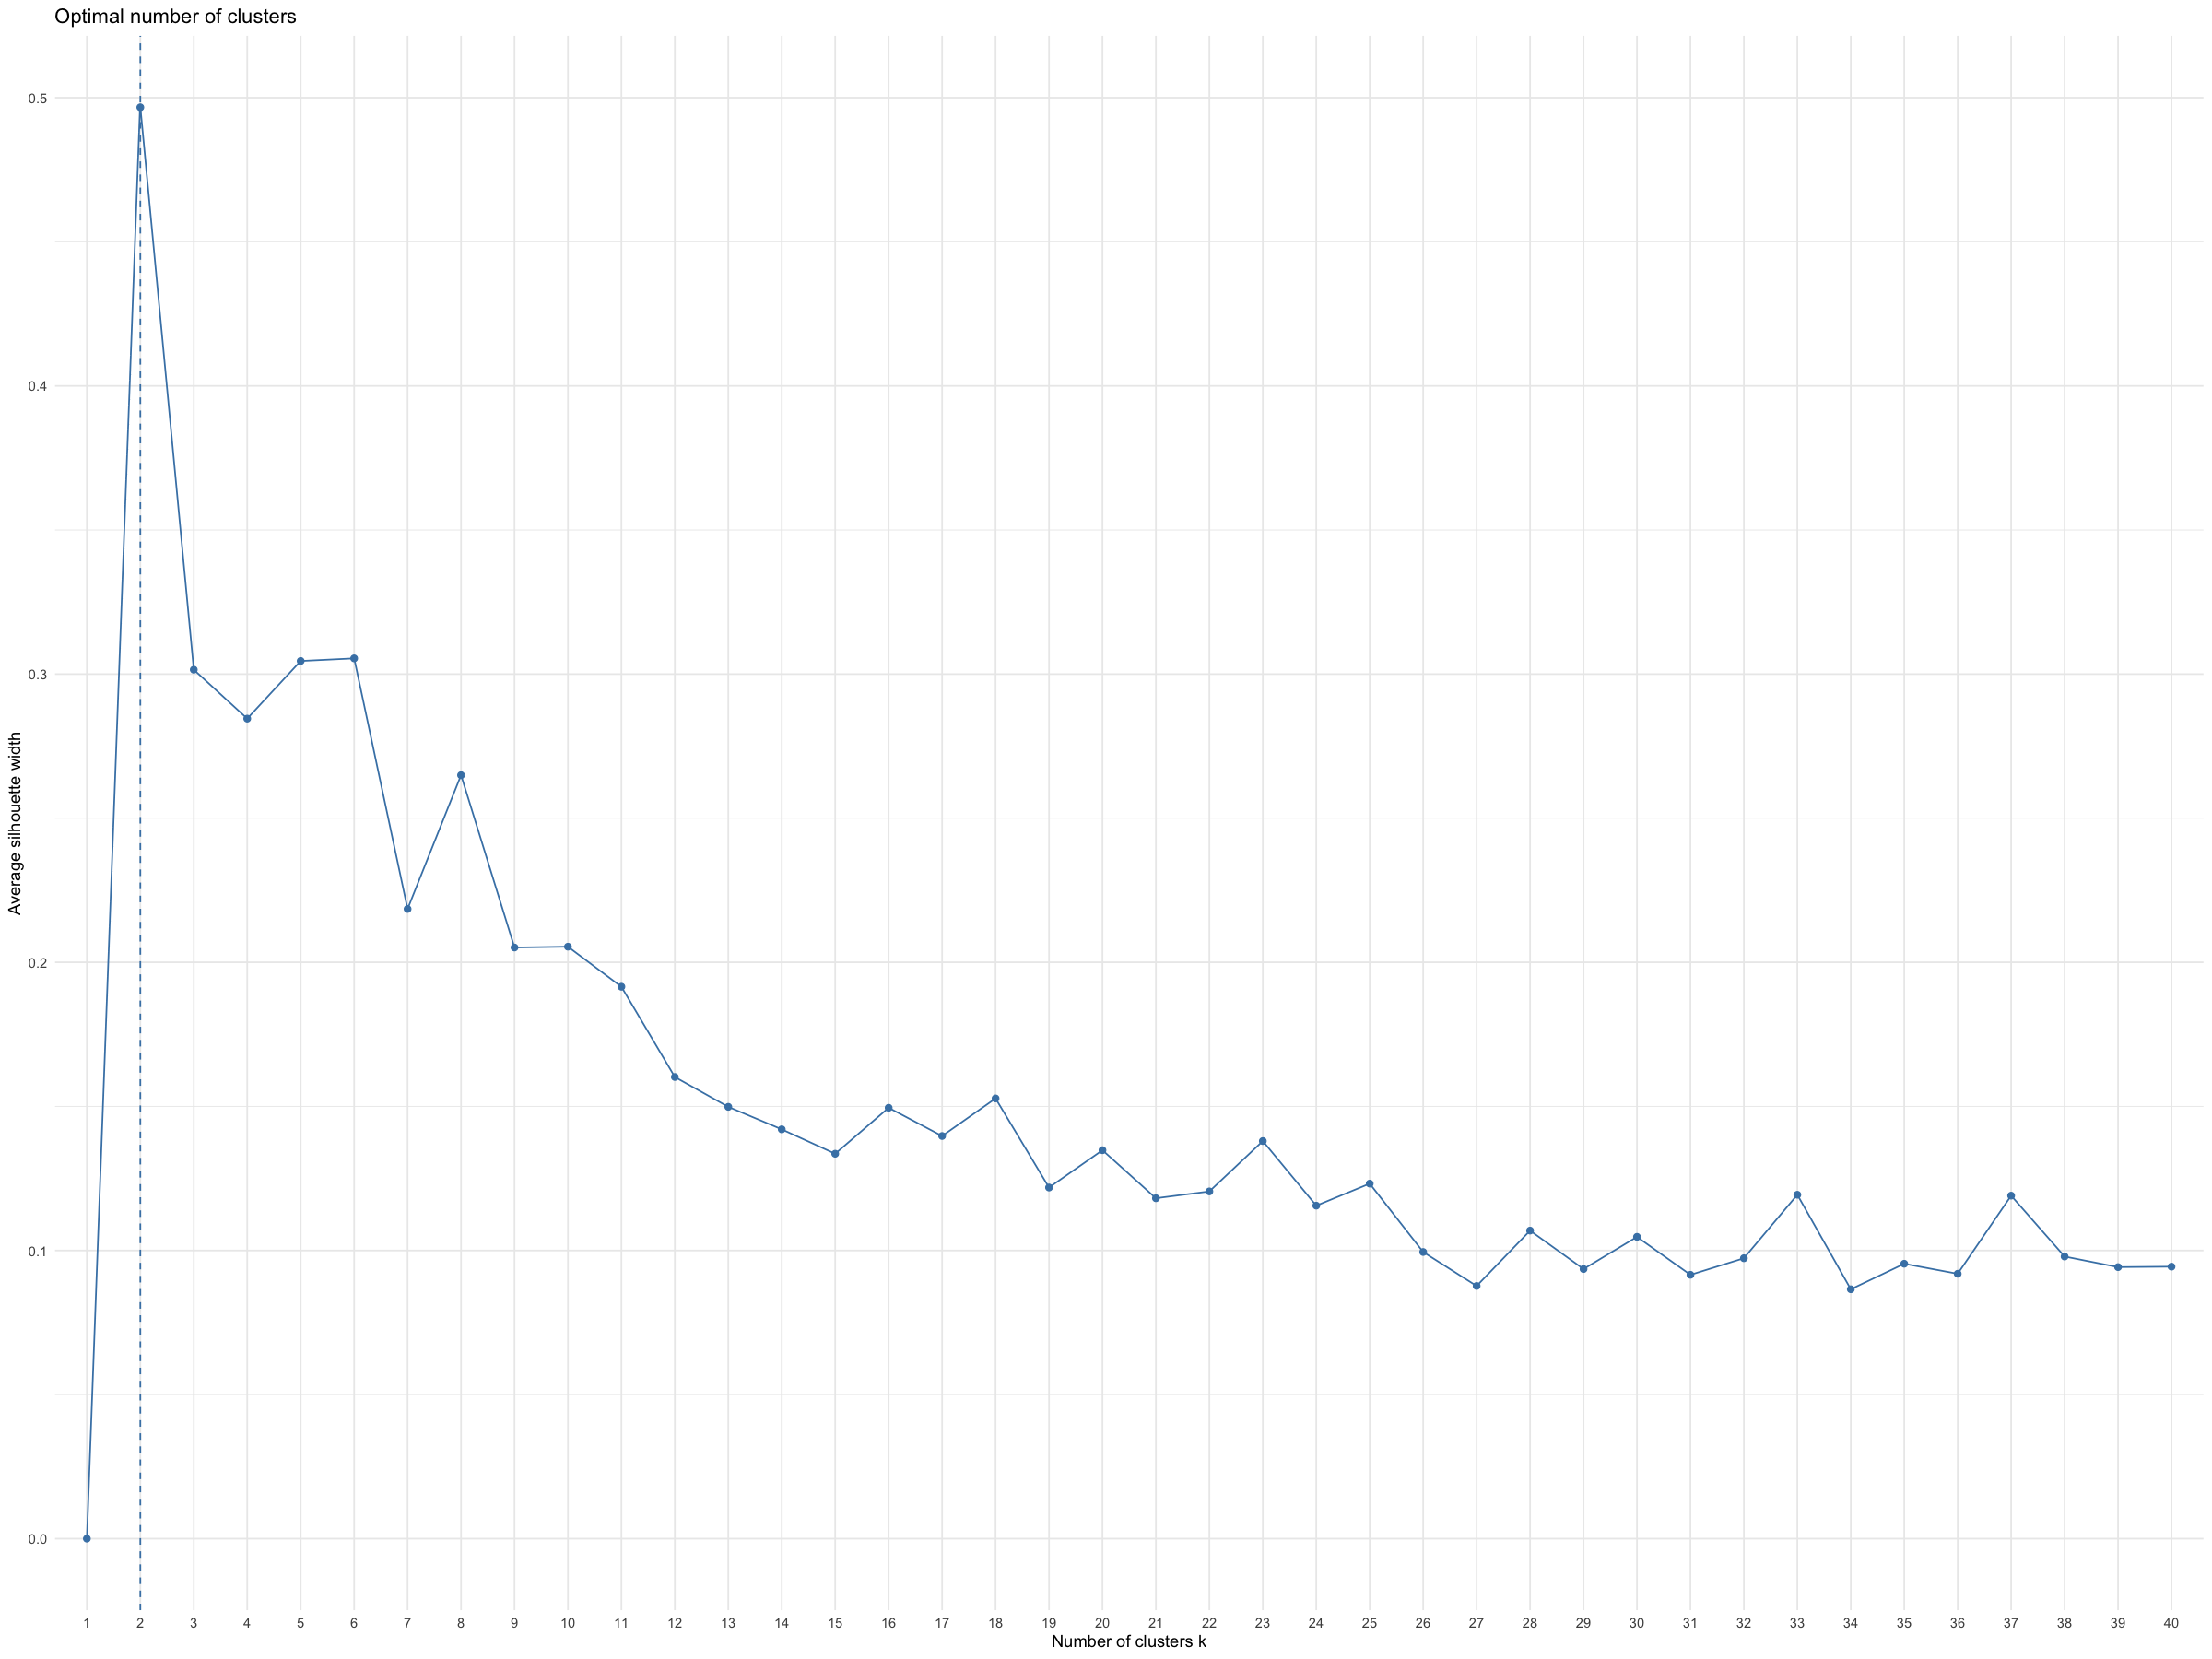

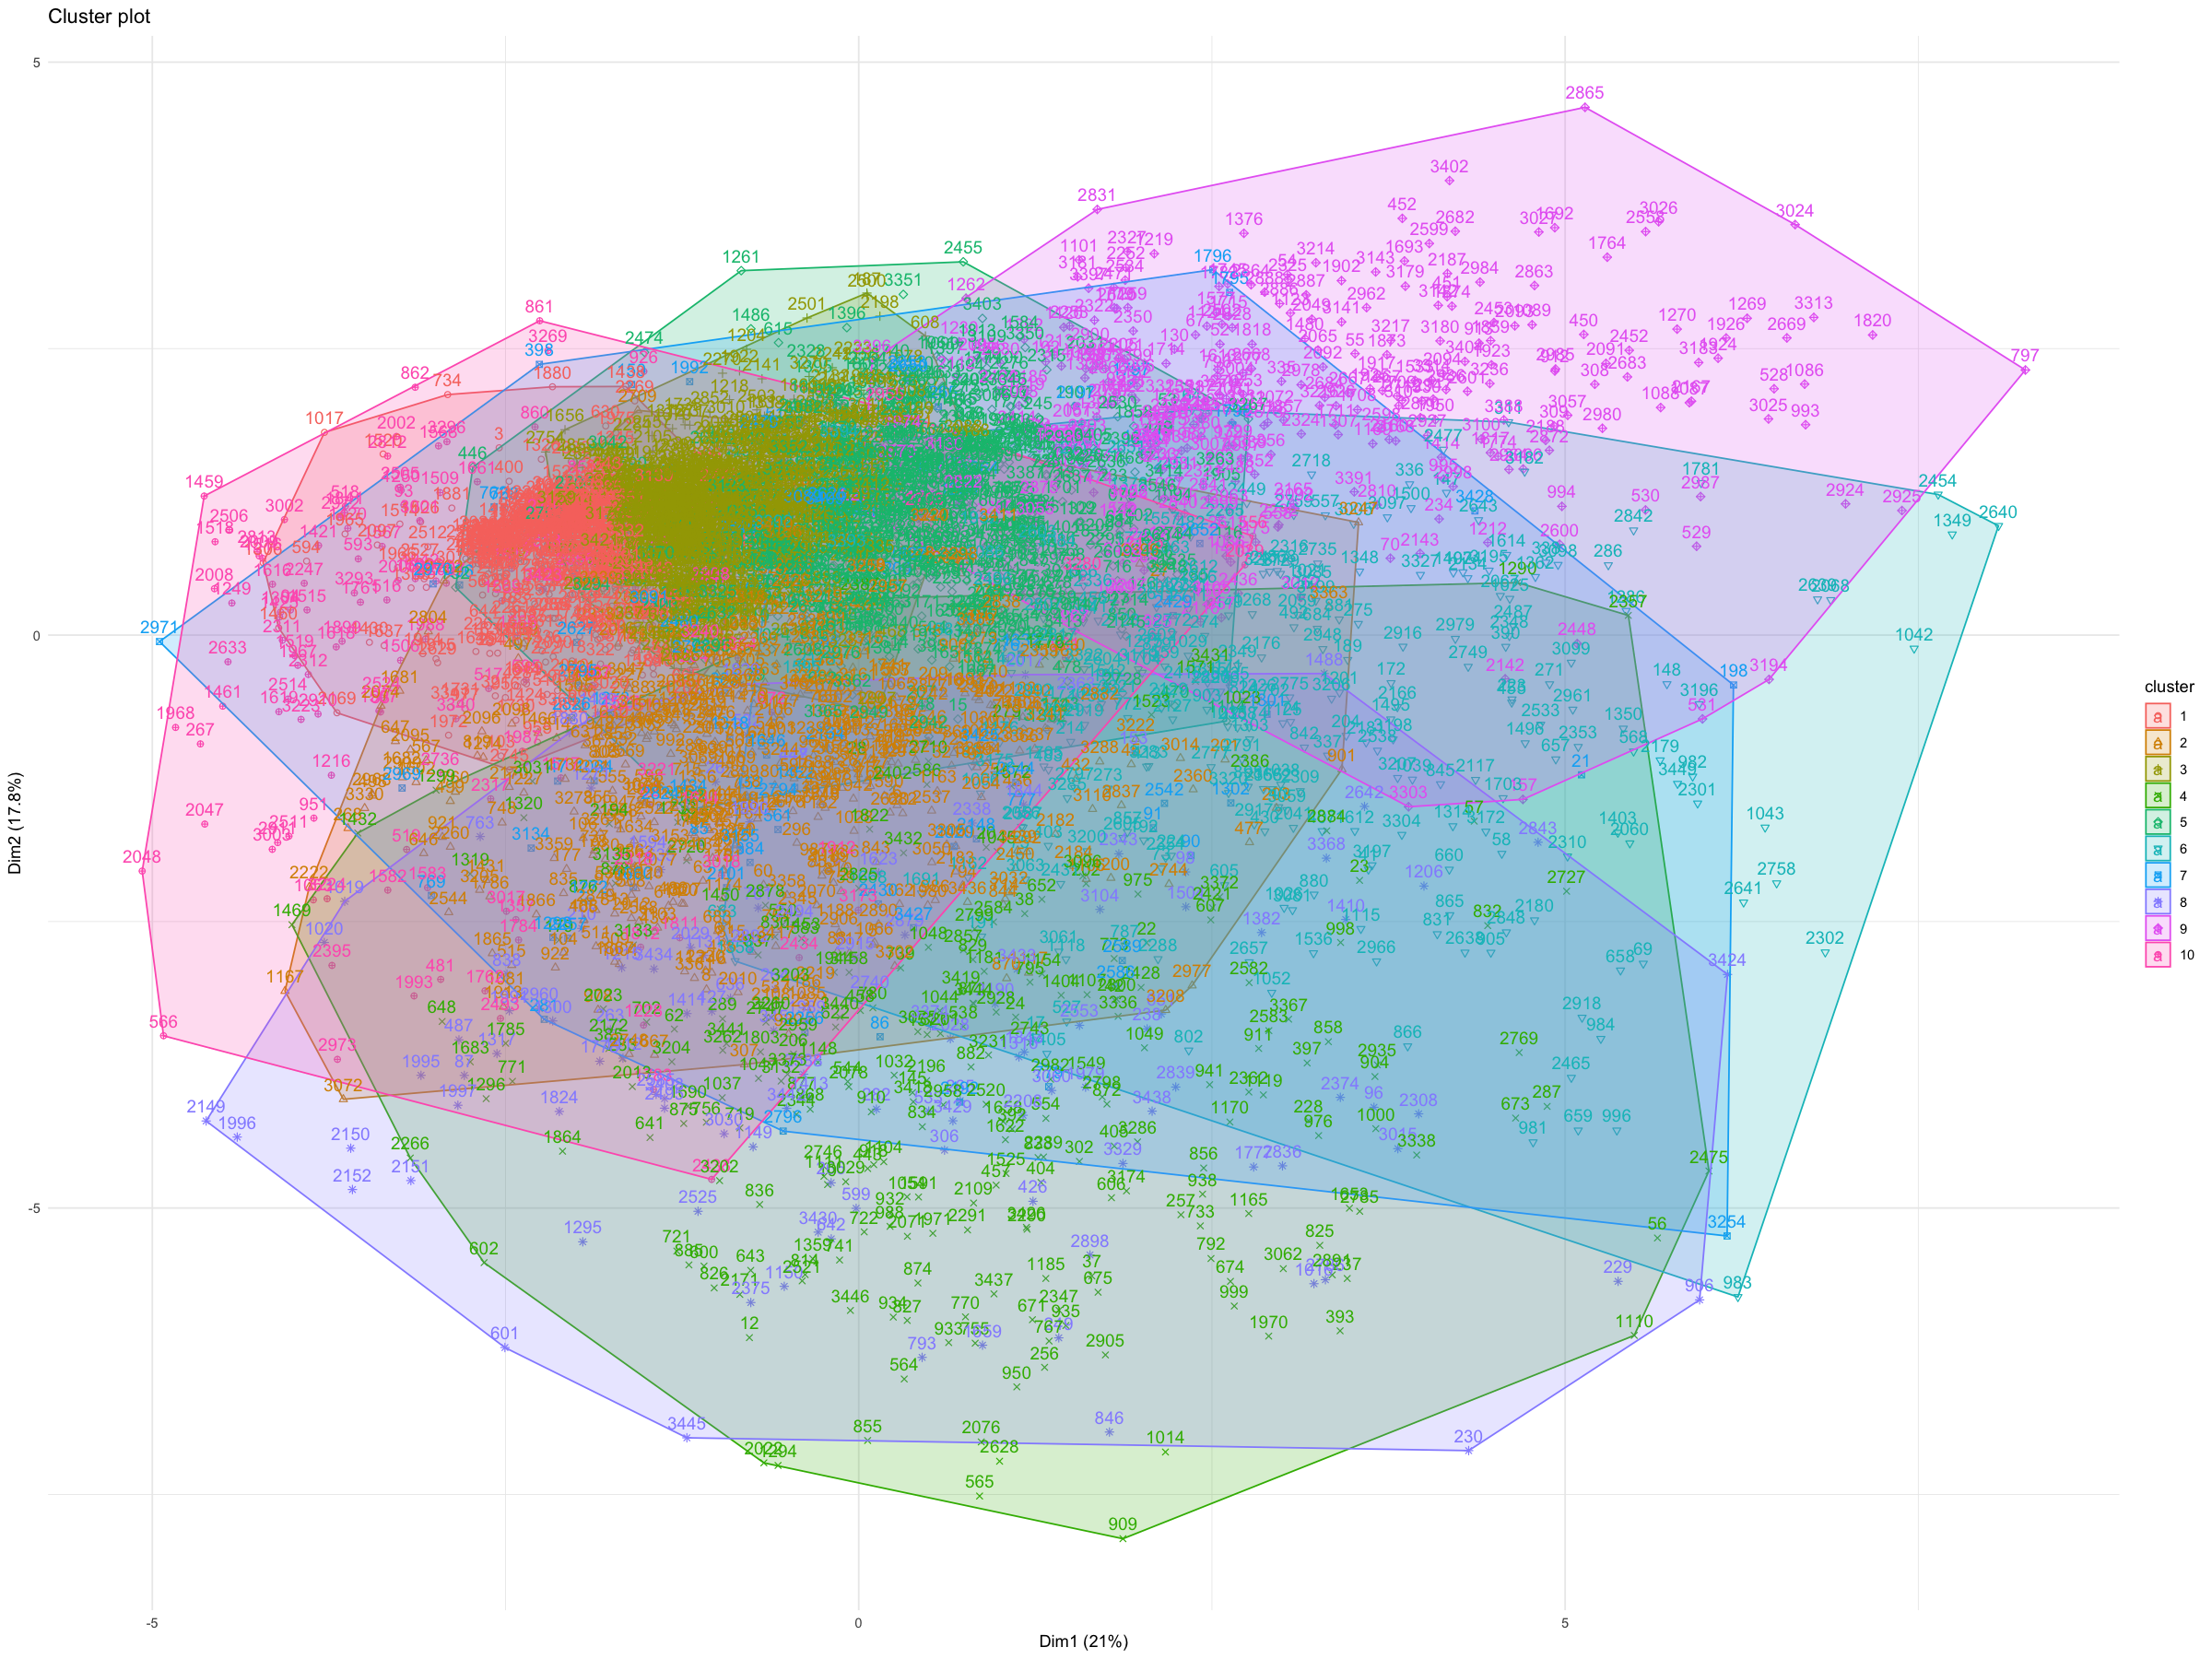

In [296]:
# do PCA on the wide_data_presence
library(FactoMineR)
library(factoextra)

# perform the PCA
pca <- PCA(wide_data_presence[, -c("id", "year")], graph = FALSE, ncp = 20)
predictions <- predict(pca, wide_data_presence[, -c("id", "year")], ncp = 20)
coords_pred <- data.table(id = wide_data_presence$id, year = wide_data_presence$year, predictions$coord)
head(coords_pred)
# winsorise all dims of coords_pred
library(DescTools)
coords_pred <-
    coords_pred %>%
    mutate_at(vars(-c("id", "year")),
        Winsorize,
        probs = c(0.05, 0.95)
    ) %>%
    as.data.table()
# remove outliers

# run clustering on predictions
library(cluster)
library(factoextra)

fviz_nbclust(coords_pred[, -c("id", "year")], FUNcluster = kmeans, method = "silhouette", k.max = 40, iter.max = 30) +
    theme_minimal()

# run k medoids
kmedoids_results <- pam(coords_pred[, -c("id", "year")],
    k = 10, metric = "manhattan"
)
# plot the clusters
fviz_cluster(kmedoids_results,
    data = coords_pred[, -c("id", "year")],
    ellipse.type = "convex", repel = F
) +
    theme_minimal()

# add the cluster to the data
wide_data_presence$cluster <- kmedoids_results$clustering


The downloaded binary packages are in
	/var/folders/gr/r594hq9j4klg4g_b0qwqkpdc0000gp/T//Rtmp4wuqGt/downloaded_packages


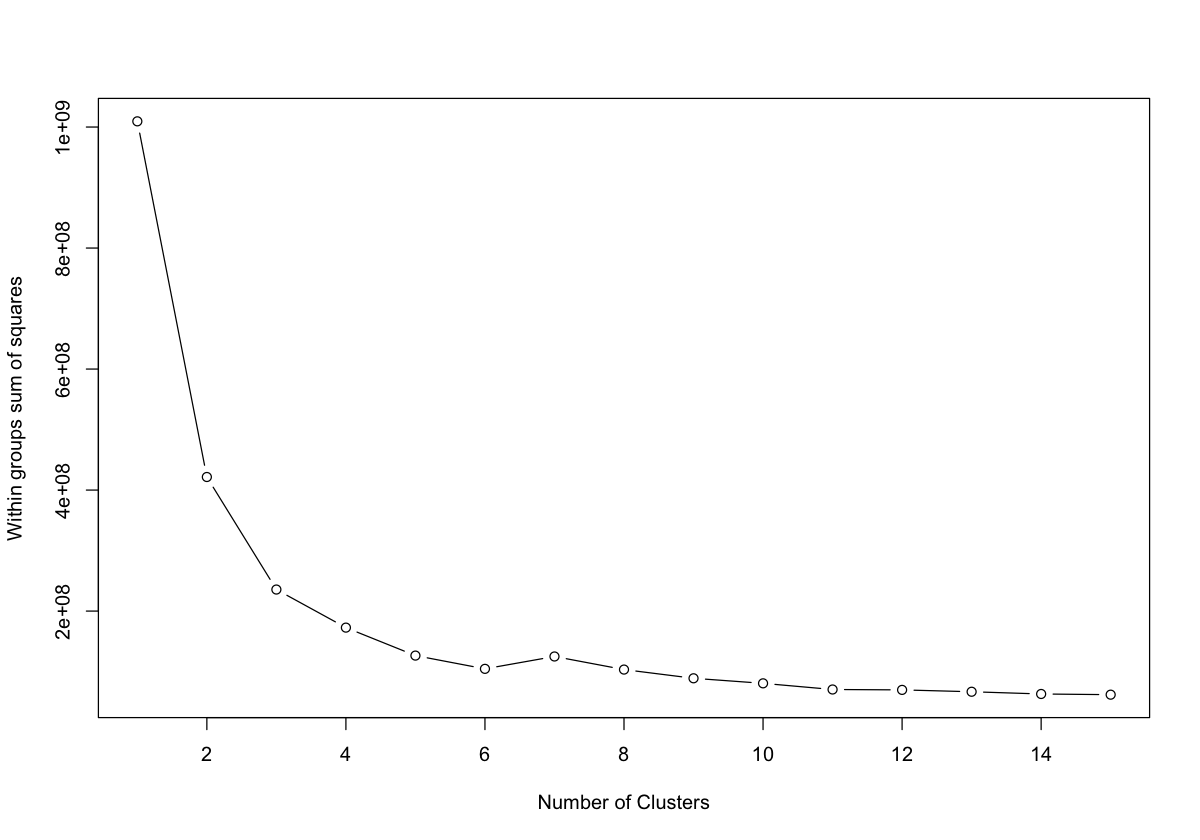

ERROR: Error in write_fst(x, path, compress, uniform_encoding): There was an error creating the file, please check path


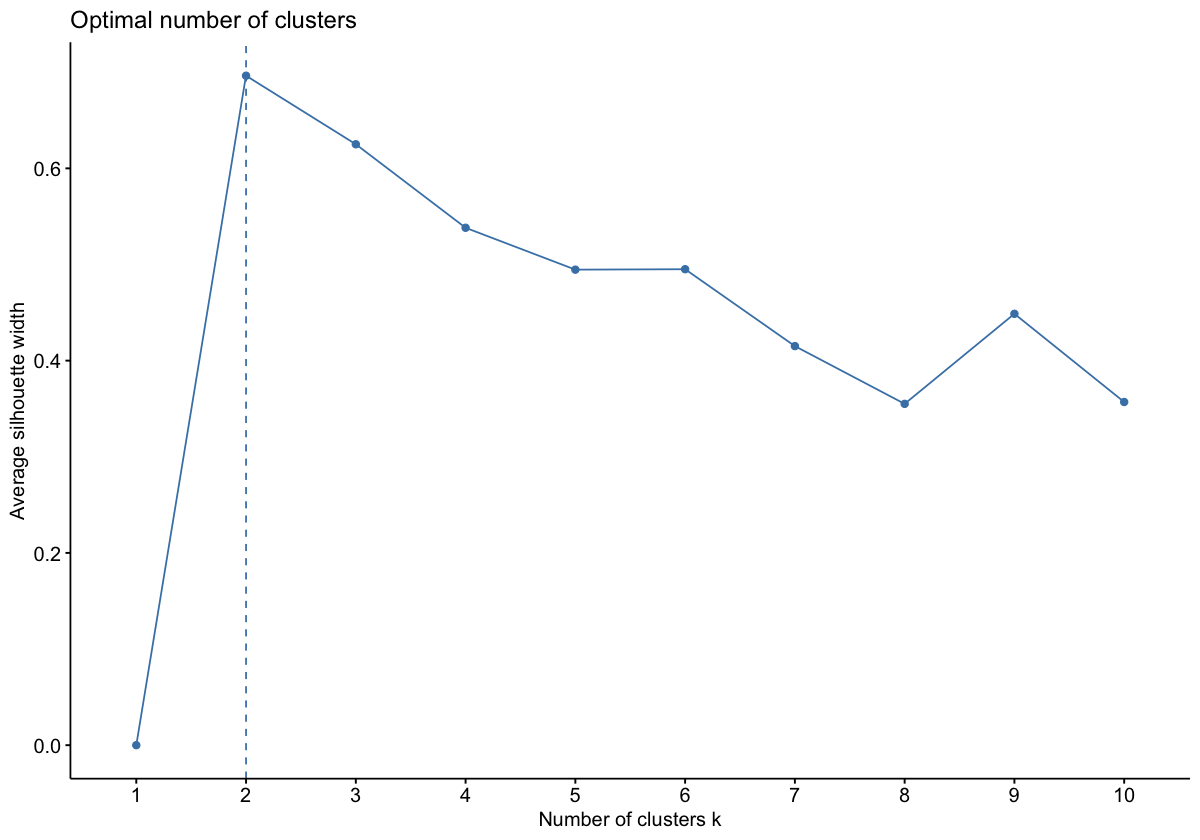

In [108]:
# lets cluster, we will use k-means clustering
install.packages("cluster")
library(cluster)

# we will use the elbow method to find the optimal number of clusters
# we will use the silhouette method to find the optimal number of clusters

# elbow method
wss <- (nrow(wide_data) - 1) * sum(apply(wide_data[, -c("id", "year")], 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(wide_data[, -c("id", "year")], centers = i)$withinss)
plot(1:15, wss, type = "b", xlab = "Number of Clusters", ylab = "Within groups sum of squares")

# silhouette method
library(factoextra)
fviz_nbclust(wide_data[, -c("id", "year")], FUNcluster = kmeans, method = "silhouette")

# we will use 5 clusters

# run k-means clustering
kmeans_model = kmeans(wide_data[, -c("id", "year")], centers = 5)

# add the cluster number to the data
wide_data$cluster = kmeans_model$cluster

# save the data to fst
write.fst(wide_data, "wide_data_clustered.fst")

# Exploratory data analysis

In [216]:
mi_codes <- 
colnames(wide_data) %>%
    startsWith("I21")

colnames(wide_data)[mi_codes]

[1] "I214"  "I21A1" "I219"  "I2119" "I213"  "I2109" "I2121" "I21A9" "I2102" "I2129" "I2101" "I2111"

In [317]:
# presence of digestive tract cancer in each of the clusters
cancer_codes <-
    colnames(wide_data_presence) %>%
    substr(1, 3) %in%
    c("C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26")

#colnames(wide_data_presence)[cancer_codes]

wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of cancer patients are in each cluster
total_cancer <- wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_cancer
wide_data_presence[, c(colnames(wide_data_presence)[cancer_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_cancer, by = cluster][order(-V1)]


cluster mean        
1  10      0.0164251208
2   8      0.0017818959
3   1      0.0010951703
4   2      0.0008469791
5   6      0.0008021819
6   5      0.0006617696
7   4      0.0005095109
8   9      0.0004924722
9   3      0.0004675082
10  7      0.0000000000

[1] 111

cluster V1        
1  10      0.34234234
2   5      0.13513514
3   2      0.11711712
4   3      0.11711712
5   1      0.09909910
6   6      0.06306306
7   8      0.04504505
8   9      0.04504505
9   4      0.03603604
10  7      0.00000000

In [331]:
# presence of MI in each of the clusters
mi_codes <-
    colnames(wide_data_presence) %>%
    substr(1, 3) %in%
    c("I21")

# colnames(wide_data_presence)[mi_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of MI patients are in each cluster
total_mi <- wide_data_presence[, c(colnames(wide_data_presence)[mi_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mi
wide_data_presence[, c(colnames(wide_data_presence)[mi_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mi, by = cluster][order(-V1)]

cluster mean        
1   8      0.0239071038
2   4      0.0188802083
3   7      0.0137457045
4   2      0.0095598846
5  10      0.0043209877
6   6      0.0039975400
7   9      0.0016181230
8   5      0.0006341958
9   3      0.0005600358
10  1      0.0002099076

[1] 148

cluster V1         
1   4      0.290540541
2   2      0.229729730
3   8      0.182432432
4   6      0.087837838
5   7      0.074324324
6   3      0.033783784
7   5      0.033783784
8  10      0.033783784
9   9      0.027027027
10  1      0.006756757

In [324]:
# presence of schizophrenia in each of the clusters

mental_codes <-
    colnames(wide_data_presence) %>%
    substr(1, 3) %in%
    c("F20", "F21", "F22", "F23", "F24", "F25", "F26", "F27", "F28", "F29")
# colnames(wide_data_presence)[mental_codes]

wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, lapply(.SD, mean), by = cluster][, .(mean = rowMeans(.SD)), by = cluster][order(-mean)]

# what percent of mental patients are in each cluster
total_mental <- wide_data_presence[, c(colnames(wide_data_presence)[mental_codes]), with = F][, (rowSums(.SD) > 0) * 1] %>% sum()
total_mental
wide_data_presence[, c(colnames(wide_data_presence)[mental_codes], "cluster"), with = F][, sum(rowSums(.SD) > 0) / total_mental, by = cluster][order(-V1)]

cluster mean        
1   2      0.0152958153
2   8      0.0142076503
3   4      0.0106770833
4   1      0.0050377834
5   7      0.0034364261
6  10      0.0029629630
7   6      0.0012300123
8   3      0.0007168459
9   5      0.0005073567
10  9      0.0004314995

[1] 120

cluster V1         
1   2      0.375000000
2   1      0.158333333
3   4      0.150000000
4   8      0.116666667
5   3      0.058333333
6   7      0.041666667
7   5      0.033333333
8   6      0.033333333
9  10      0.025000000
10  9      0.008333333

In [322]:
# number of people in each cluster
wide_data_presence[, .N, by = cluster][order(-N)]

cluster N  
1   3      744
2   5      657
3   2      462
4   1      397
5   9      309
6   6      271
7   4      256
8  10      135
9   8      122
10  7       97

## Autoencoder

In [ ]:
# we will use tensorflow and kearas for autoencoders

# install.packages("tensorflow")
# install.packages("keras")
library(tensorflow)
library(keras)

# our autoencoder will have 10 hidden layers and start with high number of nodes and decrease to 10 nodes and go back to the original number of nodes
# let's create the model

# create the model
model <- keras_model_sequential() %>%
  layer_dense(units = 1000, activation = "relu", input_shape = c(1000)) %>%
  layer_dense(units = 500, activation = "relu") %>%
  layer_dense(units = 250, activation = "relu") %>%
  layer_dense(units = 100, activation = "relu") %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 25, activation = "relu") %>%
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 25, activation = "relu") %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 100, activation = "relu") %>%
  layer_dense(units = 250, activation = "relu") %>%
  layer_dense(units = 500, activation = "relu") %>%
  layer_dense(units = 1000, activation = "relu") %>%
  layer_dense(units = 1000, activation = "relu")








In [ ]:
#find charlson scores for each cluster
#find the probability of death in each cluster

# Adding physician stats

#add clusters back to the data
#find mean cost for physician grouped by patient
#find mean cost for physician/patient grouped by cluster
#add age, gender, sex, etc.
#run the multilevel model (physicians nested in clsuters)